Mount to google drive

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import dependencies.

In [22]:
import os, glob, torch, sys, json, random, math
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader

Set the SEED to ensure reproducability.

In [23]:
def set_seed(seed: int = 42):
    import random, torch, os
    import numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    return seed

seed = set_seed(42)

Define the directory.

In [24]:
root_dir = os.path.join(os.getcwd(), 'drive', 'MyDrive', 'WQF7002 Group Project')
data_dir = os.path.join(root_dir, 'wlasl_reduced')
video_dir = os.path.join(data_dir, 'videos')
pose_dir = os.path.join(data_dir, 'features_kps')
save_dir = os.path.join(root_dir, 'weights', 'sstan')

# add the notebook directory to sys.path
sys.path.insert(0, os.path.join(root_dir, 'notebook'))

Load the gloss map.

In [25]:
gloss_path = os.path.join(data_dir, "gloss_map.json")
with open(gloss_path, "r") as f:
    gloss_map = json.load(f)
gloss_map

{'accident': 0,
 'bad': 1,
 'bathroom': 2,
 'bed': 3,
 'before': 4,
 'bowling': 5,
 'candy': 6,
 'computer': 7,
 'cool': 8,
 'cousin': 9,
 'doctor': 10,
 'drink': 11,
 'find': 12,
 'go': 13,
 'good': 14,
 'help': 15,
 'hospital': 16,
 'i': 17,
 'like': 18,
 'man': 19,
 'me': 20,
 'no': 21,
 'now': 22,
 'pizza': 23,
 'please': 24,
 'short': 25,
 'son': 26,
 'tall': 27,
 'thank you': 28,
 'thanksgiving': 29,
 'thin': 30,
 'trade': 31,
 'wait': 32,
 'who': 33,
 'you': 34}

Load the metadata.

In [26]:
data = []

for entry in os.scandir(pose_dir):
    if entry.is_dir():
        gloss = entry.name

        for file_entry in os.scandir(entry.path):
            if file_entry.is_file() and file_entry.name.endswith('.npy'):

                video_id = file_entry.name[:-4]
                data.append({
                    "gloss": gloss,
                    "video_id": video_id,
                })

df = pd.DataFrame(data)
df.head(5)

,gloss,video_id
0,bad,04712
1,bad,04708
2,bad,04709
3,bad,04713
4,bad,04718


#### Build Sign Dataset

In [27]:
class SkeletonAugmentation:
    def __init__(self, rot_range=15, shift_range=0.1):
        self.rot_range = rot_range
        self.shift_range = shift_range

    def __call__(self, x):
        x = x.clone()

        theta_deg = (random.random() * 2 - 1) * self.rot_range
        theta_rad = math.radians(theta_deg)

        # random shifts between -shift_range and +shift_range
        dx = (random.random() * 2 - 1) * self.shift_range
        dy = (random.random() * 2 - 1) * self.shift_range

        # precompute Sine and Cosine
        cos_theta = math.cos(theta_rad)
        sin_theta = math.sin(theta_rad)

        # extract Coordinates
        x_coords = x[0, :, :]
        y_coords = x[1, :, :]

        # apply rotation formula
        x_new = (x_coords * cos_theta) - (y_coords * sin_theta)
        y_new = (x_coords * sin_theta) + (y_coords * cos_theta)

        # apply shifting formula
        x_new = x_new + dx
        y_new = y_new + dy

        # update the Tensor
        x[0, :, :] = x_new
        x[1, :, :] = y_new

        return x

In [28]:
# class SignDataset(Dataset):
#     def __init__(self, df, pose_root, gloss_map, transform=None):
#         self.df = df
#         self.pose_root = pose_root
#         self.gloss_map = gloss_map
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def _convert_npy_to_tensor(self, npy_path):
#         data = np.load(npy_path)

#         # convert to tensor and permute to (C, T, V)
#         tensor = torch.tensor(data, dtype=torch.float32)
#         return tensor

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         video_id = str(row["video_id"])
#         gloss = row["gloss"]
#         label = self.gloss_map[gloss]

#         video_path = os.path.join(self.pose_root, gloss, f"{video_id}.npy")
#         x = self._convert_npy_to_tensor(video_path) # (3, T, V)

#         if hasattr(self, 'transform') and self.transform is not None:
#             x = self.transform(x)

#         return {
#             "x": x,
#             "label": torch.tensor(label, dtype=torch.long),
#             "video_id": idx
#         }

Peek at a single data from Dataset.

In [29]:
# g = torch.Generator()
# g.manual_seed(seed)
# train_dataset = SignDataset(df, pose_dir, gloss_map)
# train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, generator=g)

# sample = train_loader.dataset[300]
# x = sample["x"]
# label = sample["label"]
# video_id = sample["video_id"]

# print(x.shape, label, video_id)

torch.Size([3, 32, 75]) tensor(27) 300


In [35]:
class FastSignDataset(Dataset):
    def __init__(self, npz_path, transform=None):
        loaded = np.load(npz_path)
        self.data = loaded['X_kps']
        self.labels = loaded['y']
        self.transform = transform

        print(f"✅ FastSignDataset loaded!")
        print(f"   Data Shape: {self.data.shape}")
        print(f"   Labels Shape: {self.labels.shape}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx]).clone()
        y = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            x = self.transform(x)

        return {
            "x": x,
            "label": y,
        }

In [31]:
npz_path = os.path.join(data_dir, "tensors", "kps", "train.npz")
X = np.load(npz_path)
X_kps = X['X_kps']
y = X['y']
print("Keys in file:", list(X.keys()))
print(f"Shape of X_kps: {X_kps.shape}")
print(f"Shape of y: {y.shape}")

Keys in file: ['y', 'X_kps']
Shape of X_kps: (334, 3, 32, 75)
Shape of y: (334,)


Peek at a single data from Dataset.

In [37]:
g = torch.Generator()
g.manual_seed(seed)

npz_path = os.path.join(data_dir, "tensors", "kps", "train.npz")
train_dataset = FastSignDataset(npz_path)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, generator=g)

sample = train_loader.dataset[300]
x = sample["x"]
label = sample["label"]

print(x.shape, label, video_id)

✅ FastSignDataset loaded!
   Data Shape: (334, 3, 32, 75)
   Labels Shape: (334,)
torch.Size([3, 32, 75]) tensor(16) 300


### Sequential Spatio-Temporal Attention Network (SSTAN)

#### Build Skeleton Embedding

The skeleton data as input data fed into embedding layer which changes coordinates into embedding vectors. Then, the embedding vectors were concatenated with class token, added with Sinusoidal Positional Encoding, and passed multiple spatial temporal transformer blocks.

In [10]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, seq_length, dropout=0.1) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_length = seq_length
        self.dropout = torch.nn.Dropout(p=dropout)

        # create a metrix of shape (seq_length, d_model)
        pe = torch.zeros(seq_length, d_model)

        pos = torch.arange(start=0, end=seq_length, dtype=torch.float).unsqueeze(1) # (seq_length, 1)
        div_term = torch.exp( torch.arange(start=0, end=d_model, step=2) * (-np.log(10000.0) / d_model) )

        # apply the sin and cos function
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)

        pe = pe.unsqueeze(0) # (1, seq_length, d_model)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + (self.pe[:, :x.shape[1], :].unsqueeze(2))
        return self.dropout(x)


class SkeletonEmbedding(nn.Module):
    def __init__(self, in_channels, d_model, max_frames):
        super().__init__()
        self.embedding = nn.Linear(in_channels, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.d_model = d_model
        max_len = max_frames + 1
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        B, C, T, V = x.shape
        x = x.permute(0, 2, 3, 1)                           # (B, T, V, C)
        x = x.contiguous().view(B, T * V, C)                # (B, T * V, C)
        x = self.embedding(x)                               # (B, T * V, C_emb)
        x = x.view(B, T, V, -1)                             # (B, T, V, C_emb)
        cls_token = self.cls_token.expand(B, -1, V, -1)     # (B, 1, V, C_emb)
        x = torch.cat([cls_token, x], dim=1)                # (B, T+1, V, C_emb)
        x = self.pos_encoder(x)
        x = self.dropout(x)
        return x

Check the output shape.

In [11]:
x = torch.randn(1, 3, 32, 67)
embedding = SkeletonEmbedding(3, 128, 32)

with torch.no_grad():
    output = embedding(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Spatial Attention Block

Input embedding vectors fed into each linear layer to product *query*, *key*, and *value*. These process are expressed as follows:

$$
\begin{aligned}
\text{query} = W_q(x) \\
\text{key} = W_k(x) \\
\text{value} = W_v(x)
\end{aligned}
$$
<br>
Then, the attention map was calculated by the dot product operation with *query* and *key*. Finally, the output of attention was computed by *matmul* operator with attention map and *value*, and projected by output’s linear layer as follows:

$$
\begin{aligned}
\text{output} = W_o(\text{matmul}(\text{attention}, v))
\end{aligned}
$$

In [12]:
class SpatialAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads, head_dim, seq_len, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.d_k = num_heads * head_dim
        self.seq_len = seq_len

        self.W_q = nn.Linear(d_model, self.d_k)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_k)
        self.W_o = nn.Linear(self.d_k, d_model)

    def forward(self, x):
        B, T, V, C = x.shape
        x = x.contiguous().view(B, T * V, C)                # (B, 51 * 67, 128)

        q = self.W_q(x)                                     # (B, 51 * 67, 512)
        k = self.W_k(x)                                     # (B, 51 * 67, 512)
        v = self.W_v(x)                                     # (B, 51 * 67, 512)

        # reshape: (B, T, V, num_heads, head_dim)
        q = q.view(B, T, V, self.num_heads, self.head_dim)
        k = k.view(B, T, V, self.num_heads, self.head_dim)
        v = v.view(B, T, V, self.num_heads, self.head_dim)

        # reshape: (B, T, num_heads, V, head_dim)
        q = q.permute(0, 1, 3, 2, 4)
        k = k.permute(0, 1, 3, 2, 4)
        v = v.permute(0, 1, 3, 2, 4)

        scores = torch.matmul(q, k.transpose(-2, -1))       # (B, T, num_heads, V, V)
        scores /= np.sqrt(self.head_dim)
        attn_map = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_map, v)                  # (B, T, num_heads, V, head_dim)
        output = output.permute(0, 1, 3, 2, 4)              # (B, T, V, num_heads, head_dim)
        output = output.contiguous().view(B, T*V, self.d_k) # (B, T * V, d_k)
        output = self.W_o(output)                           # (B, T * V, d_model)
        output = output.view(B, T, V, -1)                   # (B, T, V, d_model)
        return output

Check the output shape.

In [13]:
x = torch.rand(1, 33, 67, 128)
block = SpatialAttentionBlock(128, 8, 64, 67)

with torch.no_grad():
    output = block(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Temporal Attention Block

**Note**: The input embedding vector was transposed in spatial and temporal dimensions before being passed to this module.

In [14]:
from irpe import iRPE
class TemporalAttentionBlock(nn.Module):
    def __init__(self, d_model, num_heads, head_dim, seq_len, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.d_k = num_heads * head_dim
        self.seq_len = seq_len

        self.W_q = nn.Linear(d_model, self.d_k)
        self.W_k = nn.Linear(d_model, self.d_k)
        self.W_v = nn.Linear(d_model, self.d_k)
        self.W_o = nn.Linear(self.d_k, d_model)

        self.relative_pos = iRPE(
            self.head_dim, self.num_heads, mode="contextual",
            num_buckets=2*seq_len-1, method=0
        )
        self.register_buffer("rp_bucket", self._make_1d_buckets(33))

    def _make_1d_buckets(self, seq_len):
        arange = torch.arange(seq_len)
        buckets = arange[:, None] - arange[None, :] + (seq_len - 1)
        return buckets.long()

    def forward(self, x):
        B, V, T, C = x.shape
        x = x.contiguous().view(B, T * V, C)                # (B, 67 * 51, 128)

        q = self.W_q(x)                                     # (B, 67 * 51, 512)
        k = self.W_k(x)                                     # (B, 67 * 51, 512)
        v = self.W_v(x)                                     # (B, 67 * 51, 512)

        # reshape: (B, V, T, num_heads, head_dim)
        q = q.view(B, V, T, self.num_heads, self.head_dim)
        k = k.view(B, V, T, self.num_heads, self.head_dim)
        v = v.view(B, V, T, self.num_heads, self.head_dim)

        # reshape: (B, V, num_heads, T, head_dim)
        q = q.permute(0, 1, 3, 2, 4)
        k = k.permute(0, 1, 3, 2, 4)
        v = v.permute(0, 1, 3, 2, 4)

        scores = torch.matmul(q, k.transpose(-2, -1))                           # (B, V, num_heads, T, T)

        # --- Start RPE Application ---
        q_rpe = q.contiguous().view(B*V, self.num_heads, T, self.head_dim)      # (V, num_heads, T, head_dim)
        cur_buckets = self.rp_bucket[:T, :T]
        num_buckets = self.relative_pos.num_buckets
        offsets = torch.arange(
            0, T * num_buckets, num_buckets,
            device=cur_buckets.device, dtype=cur_buckets.dtype
        ).view(-1, 1)
        ctx_indices = (cur_buckets + offsets).flatten()
        self.relative_pos._ctx_rp_bucket_flatten = ctx_indices
        pos_score = self.relative_pos.forward_rpe_transpose(q_rpe, cur_buckets) # (B * V, num_heads, T, T)
        pos_score = pos_score.view(B, V, self.num_heads, T, T)                  # (B, V, num_heads, T, T)
        # --- End RPE Application ---

        scores = (scores + pos_score)
        scores /= np.sqrt(self.head_dim)
        attn_map = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_map, v)                                      # (B, V, num_heads, T, head_dim)

        output = output.permute(0, 1, 3, 2, 4)                                  # (B, V, T, num_heads, head_dim)
        output = output.contiguous().view(B, V * T, self.d_k)                   # (B, V * T, d_k)
        output = self.W_o(output)                                               # (B, V * T, C_emb)
        output = output.contiguous().view(B, V, T, -1)                          # (B, V , T, C_emd)
        return output

/content/drive/MyDrive/WQF7002 Group Project/notebook/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


Check the output shape.

In [15]:
x = torch.randn(1, 33, 67, 128)
temporal_block = TemporalAttentionBlock(128, 8, 64, 67)

with torch.no_grad():
    x = x.permute(0, 2, 1, 3)
    output = temporal_block(x)

print(output.shape)

torch.Size([1, 67, 33, 128])


#### Build Feed Forward Network

The feed forward network that has *two linear projection layers* and *one activation function*. The input vector is *expanded to a dimension 4.0 times larger* than the embedding dimension by a first linear projection layer then nonlinearly transformed via an GELU activation function, and then converted back to a lower dimension by another linear projection layer, where the vector is merged by addition.
<br><br>
This process is expressed as follows:

$$
\begin{aligned}
x_{ff_n} &= GELU(W_1(x)) \\
x &= W_2(x_{ff_n})+x
\end{aligned}
$$


In [16]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, expand_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(d_model * expand_ratio)
        self.fc1 = nn.Linear(d_model, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, d_model)
        self.dropout = nn.Dropout(dropout)
        self.gelu = nn.GELU()

    def forward(self, x):
        x_ff = self.fc1(x)
        x_ff = self.gelu(x_ff)
        x_ff = self.dropout(x_ff)
        x = self.fc2(x_ff) + x
        return x

Check the output shape.

In [17]:
x = torch.randn(1, 33, 67, 128)
network = FeedForwardNetwork(128)

with torch.no_grad():
    output = network(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Spatial-Temporal Transformer Block

This block mainly consisted of 3 components : Multihead Self-Attention for spatial dimension, Multihead Self-Attention for tempral dimension with Relative Positional Encoding, and Feed Forward Network. Applied B2T Connection to skips all sub-layer to stable the side effect of Post-Norm.

In [18]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, head_dim, seq_len, expand_ratio=4.0, dropout=0.1, ffn_dropout=0.25, stochastic_depth=0.25):
        super().__init__()
        self.spatial_block = SpatialAttentionBlock(d_model, num_heads, head_dim, seq_len)
        self.temporal_block = TemporalAttentionBlock(d_model, num_heads, head_dim, seq_len)
        self.ffn = FeedForwardNetwork(d_model, expand_ratio, ffn_dropout)
        self.bn1 = nn.BatchNorm2d(d_model)
        self.bn2 = nn.BatchNorm2d(d_model)
        self.bn3 = nn.BatchNorm2d(d_model)
        self.stochastic_depth = stochastic_depth

    def forward(self, x):
        B, T, V, C = x.shape

        # stochastic Depth (DropPath)
        if self.training and self.stochastic_depth > 0:
            drop_prob = torch.rand(1).item()
            if drop_prob < self.stochastic_depth:
                return x

        residual = x
        output = self.spatial_block(x)          # (B, T, V, C_emb)
        output = output + residual              # (B, T, V, C_emb)

        output = output.permute(0, 3, 2, 1)     # (B, C_emb, V, T)
        output = self.bn1(output)
        output = output.permute(0, 3, 2, 1)     # (B, T, V, C_emb)

        residual = output
        output = output.permute(0, 2, 1, 3)     # (B, V, T, C_emb)
        output = self.temporal_block(output)    # (B, V, T, C_emd)
        output = output.permute(0, 2, 1, 3)     # (B, T, V, C_emb)
        output = output + residual

        output = output.permute(0, 3, 2, 1)      # (B, C_emb, V, T)
        output = self.bn2(output)
        output = output.permute(0, 3, 2, 1)      # (B, T, V, C_emb)

        residual = output
        output = self.ffn(output)                # (B, T, V, C_emb)
        output = x + residual + output           # B2T connection logic

        output = output.permute(0, 3, 2, 1)      # (B, C_emb, V, T)
        output = self.bn3(output)
        output = output.permute(0, 3, 2, 1)      # (B, T, V, C_emb)

        return output

Check the ouput shape.

In [19]:
x = torch.randn(1, 33, 67, 128)
block = TransformerBlock(128, 8, 64, 67)

with torch.no_grad():
    output = block(x)

print(output.shape)

torch.Size([1, 33, 67, 128])


#### Build Stack Transformer Model (SSTAN)

In [20]:
class SSTAN(nn.Module):
    def __init__(self, num_classes, max_frames, in_channels=3, seq_len=67, d_model=128, num_heads=4, head_dim=64, num_layers=5):
        super().__init__()
        self.embedding = SkeletonEmbedding(in_channels, d_model, max_frames)
        self.transformer_encoder = nn.ModuleList([TransformerBlock(d_model, num_heads, head_dim, seq_len) for _ in range(num_layers)])
        self.classifier = nn.Sequential(
            # nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)                       # (B, C, T, V)

        for block in self.transformer_encoder:
            x = block(x)
        cls_output = x[:, 0, :].mean(dim=1)         # (B, C_emb)

        logits = self.classifier(cls_output)
        return logits

In [21]:
x = torch.randn(1, 3, 32, 67)
model = SSTAN(35, 32)

with torch.no_grad():
    output = model(x)

print(output.shape)

torch.Size([1, 35])


#### Training Loop

Define Early Stopping Mechanism

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, save_dir=''):
        self.patience = patience
        self.min_delta = min_delta
        self.save_dir = save_dir
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model, val_loss, epoch)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(model, val_loss, epoch)
            self.counter = 0

    def save_checkpoint(self, model, val_loss, epoch):
        file_name = f"vqa_epoch{epoch+1}_loss{val_loss:.4f}.pth"
        save_path = os.path.join(self.save_dir, file_name)

        torch.save(model.state_dict(), save_path)
        print(f'Model saved to {save_path}')

Define how the data is being split.

In [23]:
from sklearn.model_selection import train_test_split

test_size= 0.15
train_df, test_df = train_test_split(df, test_size=test_size, stratify=df['gloss'], random_state=seed)

print("Shape check:")
print(f"Train: {len(train_df)}")
print(f"Test:  {len(test_df)}")

Shape check:
Train: 334
Test:  60


Define the hyperparameters.

In [24]:
epochs = 500
batch_size = 16
learning_rate = 1e-3
num_classes = 35
num_frames = 32
warmup_init_lr = 1e-4
warmup_epochs = 5
start_factor = warmup_init_lr / learning_rate
SWITCH_EPOCH = 50

Define the Dataset and DataLoader.

In [25]:
g = torch.Generator()
g.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

augmentor = SkeletonAugmentation(rot_range=15, shift_range=0.1)
train_dataset = SignDataset(train_df, pose_dir, gloss_map, augmentor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator=g)

Define the model and scheduler.

In [26]:
# setup
model = SSTAN(num_classes, num_frames, num_heads=2, num_layers=2).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

# define scheduler
warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=start_factor, end_factor=1.0, total_iters=warmup_epochs)
cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs - warmup_epochs, eta_min=1e-5, last_epoch=-1)
scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_epochs])

# scheduler_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.1, min_lr=1e-4, patience=5
# )
# scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=epochs - SWITCH_EPOCH, eta_min=1e-6
# )

# early stopping
early_stopper = EarlyStopping(patience=5, save_dir=save_dir)

# gradient accumulation
accumulation_steps = 16

Check the total number of parameters.

In [27]:
params_count = sum(p.numel() for p in model.parameters())
print("total params:", params_count)

total params: 568355


Train the SSTAN model

In [28]:
train_losses, train_accs = [], []

for epoch in range(epochs):
    # ------------ training phrase ------------
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    optimizer.zero_grad()
    batch_iterator = tqdm(train_loader, leave=True, desc=f'Processing epoch {epoch+1:02d}')

    for i, batch in enumerate(batch_iterator):
        inputs = batch["x"].to(device)
        labels = batch["label"].to(device)
        video_id = batch["video_id"].to(device)

        # print(inputs.shape)

        # forward pass
        logits = model(inputs)
        loss = criterion(logits, labels)

        # backward pass
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            # clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)

            # Update weights
            optimizer.step()
            optimizer.zero_grad()

        # update statistics
        current_loss = loss.item() * accumulation_steps
        train_loss += current_loss

        _, predicted = torch.max(logits.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()

        train_correct += correct
        train_total += total

        # update progress bar
        batch_iterator.set_postfix(
            loss=f"{current_loss:.4f}",
            acc=f"{(correct/total)*100:.2f}",
            lr=f"{optimizer.param_groups[0]['lr']:.2e}"
        )

    # calculate average training metrics
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100. * train_correct / train_total

    # update learning rate scheduler
    # if epoch == SWITCH_EPOCH:
    #     scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
    #         optimizer,
    #         T_max=epochs - SWITCH_EPOCH,
    #         eta_min=1e-6
    #     )
    # if epoch < 50:
    #     # Phase 1: Monitor Validation Loss
    #     print(f"Epoch {epoch}: Using ReduceLROnPlateau")
    #     scheduler_plateau.step(avg_train_loss)
    # else:
    #     # Phase 2: Decay smoothly to zero
    #     print(f"Epoch {epoch}: Using CosineAnnealingLR")
    #     scheduler_cosine.step()

    # update learning rate scheduler
    # scheduler.step(avg_train_loss) # ReduceLROnPlateau
    scheduler.step() # CosineAnnealingLR

    # store metrics
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)

    # print epoch results
    print(f'\nEpoch [{epoch+1}/{epochs}]')
    print(f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')

    # check early stopping
    # early_stopper(avg_train_loss, model, epoch)
    # if early_stopper.early_stop and epoch > 5:
    #         print("Early stopping triggered. Training finished.")
    #         break

    print('-' * 100)

Processing epoch 01: 100%|██████████| 21/21 [03:39<00:00, 10.44s/it, acc=0.00, loss=3.9427, lr=1.00e-04]



Epoch [1/500]
Train Loss: 3.9328, Train Acc: 2.40%
----------------------------------------------------------------------------------------------------


Processing epoch 02: 100%|██████████| 21/21 [00:01<00:00, 13.22it/s, acc=0.00, loss=3.7885, lr=2.80e-04]



Epoch [2/500]
Train Loss: 3.8605, Train Acc: 2.99%
----------------------------------------------------------------------------------------------------


Processing epoch 03: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=0.00, loss=3.5887, lr=4.60e-04]



Epoch [3/500]
Train Loss: 3.6732, Train Acc: 4.49%
----------------------------------------------------------------------------------------------------


Processing epoch 04: 100%|██████████| 21/21 [00:01<00:00, 12.19it/s, acc=0.00, loss=3.4355, lr=6.40e-04]



Epoch [4/500]
Train Loss: 3.5769, Train Acc: 3.29%
----------------------------------------------------------------------------------------------------


Processing epoch 05: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s, acc=7.14, loss=3.5827, lr=8.20e-04]



Epoch [5/500]
Train Loss: 3.5656, Train Acc: 3.59%
----------------------------------------------------------------------------------------------------


Processing epoch 06: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s, acc=0.00, loss=3.7683, lr=1.00e-03]



Epoch [6/500]
Train Loss: 3.6147, Train Acc: 2.10%
----------------------------------------------------------------------------------------------------


Processing epoch 07: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=0.00, loss=3.4438, lr=1.00e-03]



Epoch [7/500]
Train Loss: 3.6018, Train Acc: 3.29%
----------------------------------------------------------------------------------------------------


Processing epoch 08: 100%|██████████| 21/21 [00:01<00:00, 13.14it/s, acc=0.00, loss=3.6036, lr=1.00e-03]



Epoch [8/500]
Train Loss: 3.5848, Train Acc: 3.89%
----------------------------------------------------------------------------------------------------


Processing epoch 09: 100%|██████████| 21/21 [00:01<00:00, 13.35it/s, acc=0.00, loss=3.5010, lr=1.00e-03]



Epoch [9/500]
Train Loss: 3.5400, Train Acc: 2.99%
----------------------------------------------------------------------------------------------------


Processing epoch 10: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s, acc=7.14, loss=3.3506, lr=1.00e-03]



Epoch [10/500]
Train Loss: 3.5189, Train Acc: 6.59%
----------------------------------------------------------------------------------------------------


Processing epoch 11: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s, acc=7.14, loss=3.3858, lr=1.00e-03]



Epoch [11/500]
Train Loss: 3.5084, Train Acc: 4.19%
----------------------------------------------------------------------------------------------------


Processing epoch 12: 100%|██████████| 21/21 [00:01<00:00, 11.68it/s, acc=0.00, loss=3.6112, lr=1.00e-03]



Epoch [12/500]
Train Loss: 3.4944, Train Acc: 4.79%
----------------------------------------------------------------------------------------------------


Processing epoch 13: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s, acc=0.00, loss=3.5574, lr=1.00e-03]



Epoch [13/500]
Train Loss: 3.4810, Train Acc: 5.09%
----------------------------------------------------------------------------------------------------


Processing epoch 14: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s, acc=7.14, loss=3.5335, lr=9.99e-04]



Epoch [14/500]
Train Loss: 3.4748, Train Acc: 4.79%
----------------------------------------------------------------------------------------------------


Processing epoch 15: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=7.14, loss=3.5541, lr=9.99e-04]



Epoch [15/500]
Train Loss: 3.4576, Train Acc: 3.59%
----------------------------------------------------------------------------------------------------


Processing epoch 16: 100%|██████████| 21/21 [00:01<00:00, 13.21it/s, acc=7.14, loss=3.4526, lr=9.99e-04]



Epoch [16/500]
Train Loss: 3.4327, Train Acc: 4.19%
----------------------------------------------------------------------------------------------------


Processing epoch 17: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s, acc=7.14, loss=3.5184, lr=9.99e-04]



Epoch [17/500]
Train Loss: 3.4428, Train Acc: 5.99%
----------------------------------------------------------------------------------------------------


Processing epoch 18: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s, acc=0.00, loss=3.5670, lr=9.99e-04]



Epoch [18/500]
Train Loss: 3.4135, Train Acc: 7.19%
----------------------------------------------------------------------------------------------------


Processing epoch 19: 100%|██████████| 21/21 [00:01<00:00, 12.13it/s, acc=0.00, loss=3.5113, lr=9.98e-04]



Epoch [19/500]
Train Loss: 3.3629, Train Acc: 8.98%
----------------------------------------------------------------------------------------------------


Processing epoch 20: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s, acc=7.14, loss=3.3056, lr=9.98e-04]



Epoch [20/500]
Train Loss: 3.3698, Train Acc: 9.58%
----------------------------------------------------------------------------------------------------


Processing epoch 21: 100%|██████████| 21/21 [00:01<00:00, 12.63it/s, acc=21.43, loss=3.1738, lr=9.98e-04]



Epoch [21/500]
Train Loss: 3.3108, Train Acc: 11.08%
----------------------------------------------------------------------------------------------------


Processing epoch 22: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=21.43, loss=3.0936, lr=9.97e-04]



Epoch [22/500]
Train Loss: 3.2811, Train Acc: 11.08%
----------------------------------------------------------------------------------------------------


Processing epoch 23: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s, acc=21.43, loss=3.2756, lr=9.97e-04]



Epoch [23/500]
Train Loss: 3.2640, Train Acc: 9.58%
----------------------------------------------------------------------------------------------------


Processing epoch 24: 100%|██████████| 21/21 [00:01<00:00, 13.06it/s, acc=0.00, loss=3.5076, lr=9.97e-04]



Epoch [24/500]
Train Loss: 3.2561, Train Acc: 11.08%
----------------------------------------------------------------------------------------------------


Processing epoch 25: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s, acc=7.14, loss=3.4456, lr=9.96e-04]



Epoch [25/500]
Train Loss: 3.2002, Train Acc: 12.87%
----------------------------------------------------------------------------------------------------


Processing epoch 26: 100%|██████████| 21/21 [00:01<00:00, 12.27it/s, acc=28.57, loss=3.1311, lr=9.96e-04]



Epoch [26/500]
Train Loss: 3.1007, Train Acc: 15.57%
----------------------------------------------------------------------------------------------------


Processing epoch 27: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s, acc=14.29, loss=3.4303, lr=9.96e-04]



Epoch [27/500]
Train Loss: 3.2145, Train Acc: 10.48%
----------------------------------------------------------------------------------------------------


Processing epoch 28: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s, acc=7.14, loss=3.3407, lr=9.95e-04]



Epoch [28/500]
Train Loss: 3.1971, Train Acc: 9.58%
----------------------------------------------------------------------------------------------------


Processing epoch 29: 100%|██████████| 21/21 [00:01<00:00, 13.08it/s, acc=14.29, loss=3.1081, lr=9.95e-04]



Epoch [29/500]
Train Loss: 3.1156, Train Acc: 9.88%
----------------------------------------------------------------------------------------------------


Processing epoch 30: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s, acc=21.43, loss=3.2636, lr=9.94e-04]



Epoch [30/500]
Train Loss: 3.1257, Train Acc: 13.17%
----------------------------------------------------------------------------------------------------


Processing epoch 31: 100%|██████████| 21/21 [00:01<00:00, 13.29it/s, acc=0.00, loss=3.5367, lr=9.94e-04]



Epoch [31/500]
Train Loss: 3.1216, Train Acc: 12.28%
----------------------------------------------------------------------------------------------------


Processing epoch 32: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s, acc=14.29, loss=2.9064, lr=9.93e-04]



Epoch [32/500]
Train Loss: 3.0567, Train Acc: 11.98%
----------------------------------------------------------------------------------------------------


Processing epoch 33: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s, acc=14.29, loss=2.9886, lr=9.93e-04]



Epoch [33/500]
Train Loss: 3.0868, Train Acc: 14.07%
----------------------------------------------------------------------------------------------------


Processing epoch 34: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s, acc=7.14, loss=3.1820, lr=9.92e-04]



Epoch [34/500]
Train Loss: 3.1226, Train Acc: 13.17%
----------------------------------------------------------------------------------------------------


Processing epoch 35: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s, acc=0.00, loss=3.6741, lr=9.92e-04]



Epoch [35/500]
Train Loss: 3.1019, Train Acc: 13.17%
----------------------------------------------------------------------------------------------------


Processing epoch 36: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s, acc=0.00, loss=2.8309, lr=9.91e-04]



Epoch [36/500]
Train Loss: 3.0910, Train Acc: 10.18%
----------------------------------------------------------------------------------------------------


Processing epoch 37: 100%|██████████| 21/21 [00:01<00:00, 13.28it/s, acc=21.43, loss=2.8361, lr=9.90e-04]



Epoch [37/500]
Train Loss: 3.0341, Train Acc: 14.97%
----------------------------------------------------------------------------------------------------


Processing epoch 38: 100%|██████████| 21/21 [00:01<00:00, 12.47it/s, acc=21.43, loss=2.9302, lr=9.90e-04]



Epoch [38/500]
Train Loss: 3.0587, Train Acc: 12.28%
----------------------------------------------------------------------------------------------------


Processing epoch 39: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s, acc=7.14, loss=3.1882, lr=9.89e-04]



Epoch [39/500]
Train Loss: 3.0277, Train Acc: 9.88%
----------------------------------------------------------------------------------------------------


Processing epoch 40: 100%|██████████| 21/21 [00:01<00:00, 12.63it/s, acc=21.43, loss=2.9629, lr=9.89e-04]



Epoch [40/500]
Train Loss: 3.0043, Train Acc: 12.87%
----------------------------------------------------------------------------------------------------


Processing epoch 41: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s, acc=21.43, loss=2.9489, lr=9.88e-04]



Epoch [41/500]
Train Loss: 3.0255, Train Acc: 15.57%
----------------------------------------------------------------------------------------------------


Processing epoch 42: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s, acc=21.43, loss=3.1938, lr=9.87e-04]



Epoch [42/500]
Train Loss: 2.9873, Train Acc: 17.66%
----------------------------------------------------------------------------------------------------


Processing epoch 43: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=28.57, loss=2.6016, lr=9.86e-04]



Epoch [43/500]
Train Loss: 3.0047, Train Acc: 16.77%
----------------------------------------------------------------------------------------------------


Processing epoch 44: 100%|██████████| 21/21 [00:01<00:00, 12.25it/s, acc=28.57, loss=2.9277, lr=9.86e-04]



Epoch [44/500]
Train Loss: 2.9153, Train Acc: 15.57%
----------------------------------------------------------------------------------------------------


Processing epoch 45: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s, acc=14.29, loss=3.2687, lr=9.85e-04]



Epoch [45/500]
Train Loss: 2.9913, Train Acc: 16.47%
----------------------------------------------------------------------------------------------------


Processing epoch 46: 100%|██████████| 21/21 [00:01<00:00, 12.30it/s, acc=28.57, loss=2.4711, lr=9.84e-04]



Epoch [46/500]
Train Loss: 2.8384, Train Acc: 21.26%
----------------------------------------------------------------------------------------------------


Processing epoch 47: 100%|██████████| 21/21 [00:01<00:00, 11.93it/s, acc=21.43, loss=3.3651, lr=9.83e-04]



Epoch [47/500]
Train Loss: 2.8566, Train Acc: 21.56%
----------------------------------------------------------------------------------------------------


Processing epoch 48: 100%|██████████| 21/21 [00:01<00:00, 13.74it/s, acc=14.29, loss=3.4040, lr=9.83e-04]



Epoch [48/500]
Train Loss: 3.0104, Train Acc: 17.07%
----------------------------------------------------------------------------------------------------


Processing epoch 49: 100%|██████████| 21/21 [00:01<00:00, 11.79it/s, acc=14.29, loss=2.9440, lr=9.82e-04]



Epoch [49/500]
Train Loss: 2.8421, Train Acc: 20.06%
----------------------------------------------------------------------------------------------------


Processing epoch 50: 100%|██████████| 21/21 [00:01<00:00, 12.75it/s, acc=35.71, loss=2.8242, lr=9.81e-04]



Epoch [50/500]
Train Loss: 2.8950, Train Acc: 17.96%
----------------------------------------------------------------------------------------------------


Processing epoch 51: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=35.71, loss=2.2441, lr=9.80e-04]



Epoch [51/500]
Train Loss: 2.8249, Train Acc: 22.16%
----------------------------------------------------------------------------------------------------


Processing epoch 52: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s, acc=21.43, loss=2.6056, lr=9.79e-04]



Epoch [52/500]
Train Loss: 2.8438, Train Acc: 18.26%
----------------------------------------------------------------------------------------------------


Processing epoch 53: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s, acc=35.71, loss=2.2468, lr=9.78e-04]



Epoch [53/500]
Train Loss: 2.7971, Train Acc: 23.05%
----------------------------------------------------------------------------------------------------


Processing epoch 54: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s, acc=50.00, loss=2.3377, lr=9.77e-04]



Epoch [54/500]
Train Loss: 2.8588, Train Acc: 21.26%
----------------------------------------------------------------------------------------------------


Processing epoch 55: 100%|██████████| 21/21 [00:01<00:00, 12.55it/s, acc=14.29, loss=2.8255, lr=9.76e-04]



Epoch [55/500]
Train Loss: 2.8009, Train Acc: 18.26%
----------------------------------------------------------------------------------------------------


Processing epoch 56: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=0.00, loss=3.2438, lr=9.75e-04]



Epoch [56/500]
Train Loss: 2.8598, Train Acc: 18.86%
----------------------------------------------------------------------------------------------------


Processing epoch 57: 100%|██████████| 21/21 [00:01<00:00, 13.45it/s, acc=21.43, loss=2.7401, lr=9.74e-04]



Epoch [57/500]
Train Loss: 2.8601, Train Acc: 18.56%
----------------------------------------------------------------------------------------------------


Processing epoch 58: 100%|██████████| 21/21 [00:01<00:00, 12.91it/s, acc=21.43, loss=2.4526, lr=9.73e-04]



Epoch [58/500]
Train Loss: 2.7698, Train Acc: 21.56%
----------------------------------------------------------------------------------------------------


Processing epoch 59: 100%|██████████| 21/21 [00:01<00:00, 13.72it/s, acc=35.71, loss=2.5090, lr=9.72e-04]



Epoch [59/500]
Train Loss: 2.8054, Train Acc: 17.07%
----------------------------------------------------------------------------------------------------


Processing epoch 60: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s, acc=28.57, loss=2.5820, lr=9.71e-04]



Epoch [60/500]
Train Loss: 2.7568, Train Acc: 22.16%
----------------------------------------------------------------------------------------------------


Processing epoch 61: 100%|██████████| 21/21 [00:01<00:00, 13.27it/s, acc=28.57, loss=2.5842, lr=9.70e-04]



Epoch [61/500]
Train Loss: 2.8011, Train Acc: 20.06%
----------------------------------------------------------------------------------------------------


Processing epoch 62: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s, acc=21.43, loss=2.6607, lr=9.69e-04]



Epoch [62/500]
Train Loss: 2.7161, Train Acc: 23.65%
----------------------------------------------------------------------------------------------------


Processing epoch 63: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=50.00, loss=2.1810, lr=9.68e-04]



Epoch [63/500]
Train Loss: 2.7242, Train Acc: 20.36%
----------------------------------------------------------------------------------------------------


Processing epoch 64: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s, acc=21.43, loss=2.9000, lr=9.67e-04]



Epoch [64/500]
Train Loss: 2.6640, Train Acc: 23.05%
----------------------------------------------------------------------------------------------------


Processing epoch 65: 100%|██████████| 21/21 [00:01<00:00, 12.03it/s, acc=14.29, loss=3.0752, lr=9.66e-04]



Epoch [65/500]
Train Loss: 2.6135, Train Acc: 27.25%
----------------------------------------------------------------------------------------------------


Processing epoch 66: 100%|██████████| 21/21 [00:01<00:00, 13.09it/s, acc=14.29, loss=2.8860, lr=9.65e-04]



Epoch [66/500]
Train Loss: 2.7590, Train Acc: 20.36%
----------------------------------------------------------------------------------------------------


Processing epoch 67: 100%|██████████| 21/21 [00:01<00:00, 13.43it/s, acc=35.71, loss=2.6934, lr=9.63e-04]



Epoch [67/500]
Train Loss: 2.7098, Train Acc: 23.65%
----------------------------------------------------------------------------------------------------


Processing epoch 68: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=0.00, loss=3.2362, lr=9.62e-04]



Epoch [68/500]
Train Loss: 2.6643, Train Acc: 24.85%
----------------------------------------------------------------------------------------------------


Processing epoch 69: 100%|██████████| 21/21 [00:01<00:00, 12.31it/s, acc=42.86, loss=2.1948, lr=9.61e-04]



Epoch [69/500]
Train Loss: 2.6818, Train Acc: 29.64%
----------------------------------------------------------------------------------------------------


Processing epoch 70: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s, acc=14.29, loss=2.5569, lr=9.60e-04]



Epoch [70/500]
Train Loss: 2.6973, Train Acc: 22.75%
----------------------------------------------------------------------------------------------------


Processing epoch 71: 100%|██████████| 21/21 [00:01<00:00, 11.80it/s, acc=64.29, loss=2.2184, lr=9.58e-04]



Epoch [71/500]
Train Loss: 2.5421, Train Acc: 27.54%
----------------------------------------------------------------------------------------------------


Processing epoch 72: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s, acc=35.71, loss=2.3214, lr=9.57e-04]



Epoch [72/500]
Train Loss: 2.6016, Train Acc: 27.25%
----------------------------------------------------------------------------------------------------


Processing epoch 73: 100%|██████████| 21/21 [00:01<00:00, 12.73it/s, acc=7.14, loss=3.0103, lr=9.56e-04]



Epoch [73/500]
Train Loss: 2.4821, Train Acc: 28.44%
----------------------------------------------------------------------------------------------------


Processing epoch 74: 100%|██████████| 21/21 [00:01<00:00, 13.01it/s, acc=35.71, loss=2.9557, lr=9.55e-04]



Epoch [74/500]
Train Loss: 2.6311, Train Acc: 27.84%
----------------------------------------------------------------------------------------------------


Processing epoch 75: 100%|██████████| 21/21 [00:01<00:00, 12.98it/s, acc=0.00, loss=3.6294, lr=9.53e-04]



Epoch [75/500]
Train Loss: 2.5942, Train Acc: 23.95%
----------------------------------------------------------------------------------------------------


Processing epoch 76: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s, acc=42.86, loss=2.0999, lr=9.52e-04]



Epoch [76/500]
Train Loss: 2.5210, Train Acc: 28.74%
----------------------------------------------------------------------------------------------------


Processing epoch 77: 100%|██████████| 21/21 [00:01<00:00, 13.22it/s, acc=0.00, loss=3.6929, lr=9.51e-04]



Epoch [77/500]
Train Loss: 2.7052, Train Acc: 25.45%
----------------------------------------------------------------------------------------------------


Processing epoch 78: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=14.29, loss=2.8220, lr=9.49e-04]



Epoch [78/500]
Train Loss: 2.5874, Train Acc: 25.45%
----------------------------------------------------------------------------------------------------


Processing epoch 79: 100%|██████████| 21/21 [00:01<00:00, 12.15it/s, acc=21.43, loss=2.8518, lr=9.48e-04]



Epoch [79/500]
Train Loss: 2.4111, Train Acc: 30.24%
----------------------------------------------------------------------------------------------------


Processing epoch 80: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s, acc=7.14, loss=3.1310, lr=9.46e-04]



Epoch [80/500]
Train Loss: 2.5137, Train Acc: 27.25%
----------------------------------------------------------------------------------------------------


Processing epoch 81: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s, acc=28.57, loss=2.5963, lr=9.45e-04]



Epoch [81/500]
Train Loss: 2.4960, Train Acc: 31.14%
----------------------------------------------------------------------------------------------------


Processing epoch 82: 100%|██████████| 21/21 [00:01<00:00, 13.20it/s, acc=64.29, loss=1.7518, lr=9.44e-04]



Epoch [82/500]
Train Loss: 2.5120, Train Acc: 27.84%
----------------------------------------------------------------------------------------------------


Processing epoch 83: 100%|██████████| 21/21 [00:01<00:00, 11.95it/s, acc=35.71, loss=2.2671, lr=9.42e-04]



Epoch [83/500]
Train Loss: 2.3541, Train Acc: 32.63%
----------------------------------------------------------------------------------------------------


Processing epoch 84: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s, acc=28.57, loss=2.6979, lr=9.41e-04]



Epoch [84/500]
Train Loss: 2.5021, Train Acc: 29.34%
----------------------------------------------------------------------------------------------------


Processing epoch 85: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s, acc=50.00, loss=1.9937, lr=9.39e-04]



Epoch [85/500]
Train Loss: 2.4421, Train Acc: 30.54%
----------------------------------------------------------------------------------------------------


Processing epoch 86: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s, acc=21.43, loss=2.4823, lr=9.38e-04]



Epoch [86/500]
Train Loss: 2.4311, Train Acc: 34.73%
----------------------------------------------------------------------------------------------------


Processing epoch 87: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s, acc=50.00, loss=1.9184, lr=9.36e-04]



Epoch [87/500]
Train Loss: 2.3501, Train Acc: 34.13%
----------------------------------------------------------------------------------------------------


Processing epoch 88: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=35.71, loss=2.3026, lr=9.34e-04]



Epoch [88/500]
Train Loss: 2.4130, Train Acc: 32.04%
----------------------------------------------------------------------------------------------------


Processing epoch 89: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s, acc=28.57, loss=2.5497, lr=9.33e-04]



Epoch [89/500]
Train Loss: 2.3809, Train Acc: 32.34%
----------------------------------------------------------------------------------------------------


Processing epoch 90: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s, acc=7.14, loss=3.0233, lr=9.31e-04]



Epoch [90/500]
Train Loss: 2.3394, Train Acc: 34.43%
----------------------------------------------------------------------------------------------------


Processing epoch 91: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s, acc=50.00, loss=1.9150, lr=9.30e-04]



Epoch [91/500]
Train Loss: 2.6128, Train Acc: 25.75%
----------------------------------------------------------------------------------------------------


Processing epoch 92: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s, acc=42.86, loss=2.0340, lr=9.28e-04]



Epoch [92/500]
Train Loss: 2.4162, Train Acc: 32.93%
----------------------------------------------------------------------------------------------------


Processing epoch 93: 100%|██████████| 21/21 [00:01<00:00, 12.13it/s, acc=14.29, loss=3.4673, lr=9.26e-04]



Epoch [93/500]
Train Loss: 2.2757, Train Acc: 38.92%
----------------------------------------------------------------------------------------------------


Processing epoch 94: 100%|██████████| 21/21 [00:01<00:00, 13.55it/s, acc=7.14, loss=3.1652, lr=9.25e-04]



Epoch [94/500]
Train Loss: 2.4038, Train Acc: 31.44%
----------------------------------------------------------------------------------------------------


Processing epoch 95: 100%|██████████| 21/21 [00:01<00:00, 13.18it/s, acc=64.29, loss=1.7794, lr=9.23e-04]



Epoch [95/500]
Train Loss: 2.3145, Train Acc: 34.43%
----------------------------------------------------------------------------------------------------


Processing epoch 96: 100%|██████████| 21/21 [00:01<00:00, 12.19it/s, acc=71.43, loss=1.6926, lr=9.21e-04]



Epoch [96/500]
Train Loss: 2.2301, Train Acc: 37.72%
----------------------------------------------------------------------------------------------------


Processing epoch 97: 100%|██████████| 21/21 [00:01<00:00, 12.58it/s, acc=50.00, loss=1.9203, lr=9.20e-04]



Epoch [97/500]
Train Loss: 2.2152, Train Acc: 41.02%
----------------------------------------------------------------------------------------------------


Processing epoch 98: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=14.29, loss=2.9553, lr=9.18e-04]



Epoch [98/500]
Train Loss: 2.2512, Train Acc: 38.32%
----------------------------------------------------------------------------------------------------


Processing epoch 99: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s, acc=28.57, loss=2.1278, lr=9.16e-04]



Epoch [99/500]
Train Loss: 2.0817, Train Acc: 41.02%
----------------------------------------------------------------------------------------------------


Processing epoch 100: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s, acc=28.57, loss=2.5947, lr=9.14e-04]



Epoch [100/500]
Train Loss: 2.3928, Train Acc: 33.83%
----------------------------------------------------------------------------------------------------


Processing epoch 101: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=42.86, loss=2.3620, lr=9.13e-04]



Epoch [101/500]
Train Loss: 2.3745, Train Acc: 35.33%
----------------------------------------------------------------------------------------------------


Processing epoch 102: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=35.71, loss=2.5398, lr=9.11e-04]



Epoch [102/500]
Train Loss: 2.2536, Train Acc: 34.43%
----------------------------------------------------------------------------------------------------


Processing epoch 103: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s, acc=28.57, loss=2.5087, lr=9.09e-04]



Epoch [103/500]
Train Loss: 2.2526, Train Acc: 38.32%
----------------------------------------------------------------------------------------------------


Processing epoch 104: 100%|██████████| 21/21 [00:01<00:00, 13.11it/s, acc=7.14, loss=2.5933, lr=9.07e-04]



Epoch [104/500]
Train Loss: 2.2649, Train Acc: 36.23%
----------------------------------------------------------------------------------------------------


Processing epoch 105: 100%|██████████| 21/21 [00:01<00:00, 12.05it/s, acc=50.00, loss=1.9571, lr=9.05e-04]



Epoch [105/500]
Train Loss: 2.0897, Train Acc: 39.22%
----------------------------------------------------------------------------------------------------


Processing epoch 106: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s, acc=50.00, loss=1.9762, lr=9.04e-04]



Epoch [106/500]
Train Loss: 2.3538, Train Acc: 35.03%
----------------------------------------------------------------------------------------------------


Processing epoch 107: 100%|██████████| 21/21 [00:01<00:00, 11.48it/s, acc=35.71, loss=1.9323, lr=9.02e-04]



Epoch [107/500]
Train Loss: 1.8982, Train Acc: 45.51%
----------------------------------------------------------------------------------------------------


Processing epoch 108: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s, acc=35.71, loss=2.2859, lr=9.00e-04]



Epoch [108/500]
Train Loss: 2.2819, Train Acc: 33.23%
----------------------------------------------------------------------------------------------------


Processing epoch 109: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s, acc=35.71, loss=2.2052, lr=8.98e-04]



Epoch [109/500]
Train Loss: 2.3186, Train Acc: 35.03%
----------------------------------------------------------------------------------------------------


Processing epoch 110: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s, acc=28.57, loss=2.1370, lr=8.96e-04]



Epoch [110/500]
Train Loss: 2.2499, Train Acc: 34.13%
----------------------------------------------------------------------------------------------------


Processing epoch 111: 100%|██████████| 21/21 [00:01<00:00, 12.00it/s, acc=50.00, loss=1.7521, lr=8.94e-04]



Epoch [111/500]
Train Loss: 2.1831, Train Acc: 36.23%
----------------------------------------------------------------------------------------------------


Processing epoch 112: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s, acc=0.00, loss=3.5218, lr=8.92e-04]



Epoch [112/500]
Train Loss: 2.0676, Train Acc: 44.31%
----------------------------------------------------------------------------------------------------


Processing epoch 113: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s, acc=14.29, loss=2.6617, lr=8.90e-04]



Epoch [113/500]
Train Loss: 2.0007, Train Acc: 46.11%
----------------------------------------------------------------------------------------------------


Processing epoch 114: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s, acc=71.43, loss=1.6088, lr=8.88e-04]



Epoch [114/500]
Train Loss: 2.0010, Train Acc: 46.71%
----------------------------------------------------------------------------------------------------


Processing epoch 115: 100%|██████████| 21/21 [00:01<00:00, 12.37it/s, acc=42.86, loss=1.7101, lr=8.86e-04]



Epoch [115/500]
Train Loss: 2.1321, Train Acc: 42.22%
----------------------------------------------------------------------------------------------------


Processing epoch 116: 100%|██████████| 21/21 [00:01<00:00, 13.65it/s, acc=57.14, loss=1.6759, lr=8.84e-04]



Epoch [116/500]
Train Loss: 2.3322, Train Acc: 38.32%
----------------------------------------------------------------------------------------------------


Processing epoch 117: 100%|██████████| 21/21 [00:01<00:00, 13.27it/s, acc=28.57, loss=2.2407, lr=8.82e-04]



Epoch [117/500]
Train Loss: 2.2886, Train Acc: 34.73%
----------------------------------------------------------------------------------------------------


Processing epoch 118: 100%|██████████| 21/21 [00:01<00:00, 12.91it/s, acc=21.43, loss=2.7974, lr=8.80e-04]



Epoch [118/500]
Train Loss: 2.2050, Train Acc: 39.52%
----------------------------------------------------------------------------------------------------


Processing epoch 119: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s, acc=50.00, loss=1.7252, lr=8.78e-04]



Epoch [119/500]
Train Loss: 2.0408, Train Acc: 44.01%
----------------------------------------------------------------------------------------------------


Processing epoch 120: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s, acc=71.43, loss=1.5803, lr=8.76e-04]



Epoch [120/500]
Train Loss: 2.0580, Train Acc: 43.71%
----------------------------------------------------------------------------------------------------


Processing epoch 121: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s, acc=42.86, loss=1.8224, lr=8.74e-04]



Epoch [121/500]
Train Loss: 2.0902, Train Acc: 41.92%
----------------------------------------------------------------------------------------------------


Processing epoch 122: 100%|██████████| 21/21 [00:01<00:00, 12.14it/s, acc=14.29, loss=3.1329, lr=8.72e-04]



Epoch [122/500]
Train Loss: 1.9890, Train Acc: 45.51%
----------------------------------------------------------------------------------------------------


Processing epoch 123: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s, acc=21.43, loss=2.5497, lr=8.70e-04]



Epoch [123/500]
Train Loss: 2.2554, Train Acc: 35.63%
----------------------------------------------------------------------------------------------------


Processing epoch 124: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s, acc=57.14, loss=1.7803, lr=8.68e-04]



Epoch [124/500]
Train Loss: 1.9914, Train Acc: 46.41%
----------------------------------------------------------------------------------------------------


Processing epoch 125: 100%|██████████| 21/21 [00:01<00:00, 13.06it/s, acc=7.14, loss=3.5338, lr=8.65e-04]



Epoch [125/500]
Train Loss: 2.1477, Train Acc: 40.72%
----------------------------------------------------------------------------------------------------


Processing epoch 126: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s, acc=50.00, loss=1.7659, lr=8.63e-04]



Epoch [126/500]
Train Loss: 2.1174, Train Acc: 42.81%
----------------------------------------------------------------------------------------------------


Processing epoch 127: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s, acc=28.57, loss=2.2635, lr=8.61e-04]



Epoch [127/500]
Train Loss: 2.1743, Train Acc: 40.42%
----------------------------------------------------------------------------------------------------


Processing epoch 128: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s, acc=71.43, loss=1.3370, lr=8.59e-04]



Epoch [128/500]
Train Loss: 2.0851, Train Acc: 41.02%
----------------------------------------------------------------------------------------------------


Processing epoch 129: 100%|██████████| 21/21 [00:01<00:00, 13.09it/s, acc=7.14, loss=2.9049, lr=8.57e-04]



Epoch [129/500]
Train Loss: 2.1675, Train Acc: 39.82%
----------------------------------------------------------------------------------------------------


Processing epoch 130: 100%|██████████| 21/21 [00:01<00:00, 12.15it/s, acc=35.71, loss=1.8403, lr=8.54e-04]



Epoch [130/500]
Train Loss: 1.9304, Train Acc: 47.60%
----------------------------------------------------------------------------------------------------


Processing epoch 131: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=78.57, loss=1.1878, lr=8.52e-04]



Epoch [131/500]
Train Loss: 1.9597, Train Acc: 42.81%
----------------------------------------------------------------------------------------------------


Processing epoch 132: 100%|██████████| 21/21 [00:01<00:00, 13.62it/s, acc=42.86, loss=2.0006, lr=8.50e-04]



Epoch [132/500]
Train Loss: 2.2112, Train Acc: 40.72%
----------------------------------------------------------------------------------------------------


Processing epoch 133: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s, acc=14.29, loss=2.8487, lr=8.48e-04]



Epoch [133/500]
Train Loss: 2.1043, Train Acc: 38.02%
----------------------------------------------------------------------------------------------------


Processing epoch 134: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s, acc=14.29, loss=3.1997, lr=8.45e-04]



Epoch [134/500]
Train Loss: 2.0741, Train Acc: 44.31%
----------------------------------------------------------------------------------------------------


Processing epoch 135: 100%|██████████| 21/21 [00:01<00:00, 13.41it/s, acc=57.14, loss=1.7220, lr=8.43e-04]



Epoch [135/500]
Train Loss: 2.1866, Train Acc: 39.82%
----------------------------------------------------------------------------------------------------


Processing epoch 136: 100%|██████████| 21/21 [00:01<00:00, 13.80it/s, acc=50.00, loss=1.4082, lr=8.41e-04]



Epoch [136/500]
Train Loss: 2.2829, Train Acc: 33.83%
----------------------------------------------------------------------------------------------------


Processing epoch 137: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s, acc=85.71, loss=1.0708, lr=8.39e-04]



Epoch [137/500]
Train Loss: 1.9675, Train Acc: 45.21%
----------------------------------------------------------------------------------------------------


Processing epoch 138: 100%|██████████| 21/21 [00:01<00:00, 12.49it/s, acc=71.43, loss=1.3686, lr=8.36e-04]



Epoch [138/500]
Train Loss: 2.0629, Train Acc: 42.51%
----------------------------------------------------------------------------------------------------


Processing epoch 139: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=28.57, loss=2.5049, lr=8.34e-04]



Epoch [139/500]
Train Loss: 1.9631, Train Acc: 45.51%
----------------------------------------------------------------------------------------------------


Processing epoch 140: 100%|██████████| 21/21 [00:01<00:00, 12.13it/s, acc=71.43, loss=1.2088, lr=8.32e-04]



Epoch [140/500]
Train Loss: 1.8534, Train Acc: 48.80%
----------------------------------------------------------------------------------------------------


Processing epoch 141: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=50.00, loss=1.6865, lr=8.29e-04]



Epoch [141/500]
Train Loss: 2.0081, Train Acc: 47.60%
----------------------------------------------------------------------------------------------------


Processing epoch 142: 100%|██████████| 21/21 [00:01<00:00, 11.85it/s, acc=35.71, loss=2.1202, lr=8.27e-04]



Epoch [142/500]
Train Loss: 1.7624, Train Acc: 54.79%
----------------------------------------------------------------------------------------------------


Processing epoch 143: 100%|██████████| 21/21 [00:01<00:00, 11.99it/s, acc=71.43, loss=1.3659, lr=8.24e-04]



Epoch [143/500]
Train Loss: 1.7333, Train Acc: 55.39%
----------------------------------------------------------------------------------------------------


Processing epoch 144: 100%|██████████| 21/21 [00:01<00:00, 12.08it/s, acc=85.71, loss=1.0966, lr=8.22e-04]



Epoch [144/500]
Train Loss: 2.0120, Train Acc: 44.31%
----------------------------------------------------------------------------------------------------


Processing epoch 145: 100%|██████████| 21/21 [00:01<00:00, 13.42it/s, acc=0.00, loss=3.5553, lr=8.20e-04]



Epoch [145/500]
Train Loss: 2.4852, Train Acc: 31.74%
----------------------------------------------------------------------------------------------------


Processing epoch 146: 100%|██████████| 21/21 [00:01<00:00, 12.79it/s, acc=71.43, loss=1.2520, lr=8.17e-04]



Epoch [146/500]
Train Loss: 2.0914, Train Acc: 44.91%
----------------------------------------------------------------------------------------------------


Processing epoch 147: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s, acc=64.29, loss=1.2357, lr=8.15e-04]



Epoch [147/500]
Train Loss: 1.7444, Train Acc: 54.19%
----------------------------------------------------------------------------------------------------


Processing epoch 148: 100%|██████████| 21/21 [00:01<00:00, 12.39it/s, acc=78.57, loss=1.2472, lr=8.12e-04]



Epoch [148/500]
Train Loss: 1.8838, Train Acc: 50.00%
----------------------------------------------------------------------------------------------------


Processing epoch 149: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s, acc=28.57, loss=2.4252, lr=8.10e-04]



Epoch [149/500]
Train Loss: 1.9116, Train Acc: 48.80%
----------------------------------------------------------------------------------------------------


Processing epoch 150: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s, acc=21.43, loss=2.4114, lr=8.07e-04]



Epoch [150/500]
Train Loss: 1.8560, Train Acc: 48.50%
----------------------------------------------------------------------------------------------------


Processing epoch 151: 100%|██████████| 21/21 [00:01<00:00, 12.49it/s, acc=0.00, loss=3.6022, lr=8.05e-04]



Epoch [151/500]
Train Loss: 1.8895, Train Acc: 48.50%
----------------------------------------------------------------------------------------------------


Processing epoch 152: 100%|██████████| 21/21 [00:01<00:00, 12.31it/s, acc=42.86, loss=1.7767, lr=8.02e-04]



Epoch [152/500]
Train Loss: 1.8591, Train Acc: 49.70%
----------------------------------------------------------------------------------------------------


Processing epoch 153: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=64.29, loss=1.3960, lr=8.00e-04]



Epoch [153/500]
Train Loss: 1.9674, Train Acc: 46.71%
----------------------------------------------------------------------------------------------------


Processing epoch 154: 100%|██████████| 21/21 [00:01<00:00, 12.42it/s, acc=64.29, loss=1.3482, lr=7.97e-04]



Epoch [154/500]
Train Loss: 1.7121, Train Acc: 54.19%
----------------------------------------------------------------------------------------------------


Processing epoch 155: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=78.57, loss=1.4126, lr=7.95e-04]



Epoch [155/500]
Train Loss: 2.0441, Train Acc: 47.01%
----------------------------------------------------------------------------------------------------


Processing epoch 156: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s, acc=78.57, loss=1.1412, lr=7.92e-04]



Epoch [156/500]
Train Loss: 1.9199, Train Acc: 47.90%
----------------------------------------------------------------------------------------------------


Processing epoch 157: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s, acc=71.43, loss=1.2386, lr=7.90e-04]



Epoch [157/500]
Train Loss: 1.7021, Train Acc: 54.19%
----------------------------------------------------------------------------------------------------


Processing epoch 158: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s, acc=35.71, loss=2.0918, lr=7.87e-04]



Epoch [158/500]
Train Loss: 1.9520, Train Acc: 45.51%
----------------------------------------------------------------------------------------------------


Processing epoch 159: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s, acc=64.29, loss=1.3411, lr=7.84e-04]



Epoch [159/500]
Train Loss: 2.1502, Train Acc: 42.22%
----------------------------------------------------------------------------------------------------


Processing epoch 160: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s, acc=0.00, loss=3.4712, lr=7.82e-04]



Epoch [160/500]
Train Loss: 1.9524, Train Acc: 48.80%
----------------------------------------------------------------------------------------------------


Processing epoch 161: 100%|██████████| 21/21 [00:01<00:00, 13.06it/s, acc=78.57, loss=1.3467, lr=7.79e-04]



Epoch [161/500]
Train Loss: 1.8779, Train Acc: 50.00%
----------------------------------------------------------------------------------------------------


Processing epoch 162: 100%|██████████| 21/21 [00:01<00:00, 14.04it/s, acc=21.43, loss=2.2369, lr=7.77e-04]



Epoch [162/500]
Train Loss: 2.1866, Train Acc: 41.92%
----------------------------------------------------------------------------------------------------


Processing epoch 163: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s, acc=14.29, loss=2.4754, lr=7.74e-04]



Epoch [163/500]
Train Loss: 1.8307, Train Acc: 50.90%
----------------------------------------------------------------------------------------------------


Processing epoch 164: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s, acc=71.43, loss=1.2387, lr=7.71e-04]



Epoch [164/500]
Train Loss: 1.6628, Train Acc: 57.19%
----------------------------------------------------------------------------------------------------


Processing epoch 165: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s, acc=0.00, loss=3.6448, lr=7.69e-04]



Epoch [165/500]
Train Loss: 2.0122, Train Acc: 45.81%
----------------------------------------------------------------------------------------------------


Processing epoch 166: 100%|██████████| 21/21 [00:01<00:00, 11.93it/s, acc=64.29, loss=1.3373, lr=7.66e-04]



Epoch [166/500]
Train Loss: 1.6116, Train Acc: 59.28%
----------------------------------------------------------------------------------------------------


Processing epoch 167: 100%|██████████| 21/21 [00:01<00:00, 12.98it/s, acc=14.29, loss=2.5981, lr=7.63e-04]



Epoch [167/500]
Train Loss: 2.0419, Train Acc: 44.61%
----------------------------------------------------------------------------------------------------


Processing epoch 168: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s, acc=85.71, loss=0.9015, lr=7.61e-04]



Epoch [168/500]
Train Loss: 1.9315, Train Acc: 47.90%
----------------------------------------------------------------------------------------------------


Processing epoch 169: 100%|██████████| 21/21 [00:01<00:00, 12.31it/s, acc=50.00, loss=2.1006, lr=7.58e-04]



Epoch [169/500]
Train Loss: 1.8255, Train Acc: 54.19%
----------------------------------------------------------------------------------------------------


Processing epoch 170: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s, acc=71.43, loss=1.2547, lr=7.55e-04]



Epoch [170/500]
Train Loss: 1.9741, Train Acc: 45.81%
----------------------------------------------------------------------------------------------------


Processing epoch 171: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s, acc=57.14, loss=1.3250, lr=7.52e-04]



Epoch [171/500]
Train Loss: 1.7467, Train Acc: 55.69%
----------------------------------------------------------------------------------------------------


Processing epoch 172: 100%|██████████| 21/21 [00:01<00:00, 12.12it/s, acc=78.57, loss=1.2459, lr=7.50e-04]



Epoch [172/500]
Train Loss: 1.5736, Train Acc: 58.68%
----------------------------------------------------------------------------------------------------


Processing epoch 173: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s, acc=35.71, loss=2.3869, lr=7.47e-04]



Epoch [173/500]
Train Loss: 1.6132, Train Acc: 58.38%
----------------------------------------------------------------------------------------------------


Processing epoch 174: 100%|██████████| 21/21 [00:01<00:00, 11.90it/s, acc=64.29, loss=1.3145, lr=7.44e-04]



Epoch [174/500]
Train Loss: 1.7209, Train Acc: 57.19%
----------------------------------------------------------------------------------------------------


Processing epoch 175: 100%|██████████| 21/21 [00:01<00:00, 13.00it/s, acc=71.43, loss=1.2728, lr=7.42e-04]



Epoch [175/500]
Train Loss: 1.9401, Train Acc: 46.71%
----------------------------------------------------------------------------------------------------


Processing epoch 176: 100%|██████████| 21/21 [00:01<00:00, 12.54it/s, acc=7.14, loss=3.0837, lr=7.39e-04]



Epoch [176/500]
Train Loss: 1.7168, Train Acc: 56.59%
----------------------------------------------------------------------------------------------------


Processing epoch 177: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=14.29, loss=2.6686, lr=7.36e-04]



Epoch [177/500]
Train Loss: 1.8882, Train Acc: 48.50%
----------------------------------------------------------------------------------------------------


Processing epoch 178: 100%|██████████| 21/21 [00:01<00:00, 14.11it/s, acc=42.86, loss=1.7925, lr=7.33e-04]



Epoch [178/500]
Train Loss: 2.1447, Train Acc: 39.22%
----------------------------------------------------------------------------------------------------


Processing epoch 179: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=14.29, loss=2.4865, lr=7.30e-04]



Epoch [179/500]
Train Loss: 1.8550, Train Acc: 52.99%
----------------------------------------------------------------------------------------------------


Processing epoch 180: 100%|██████████| 21/21 [00:01<00:00, 13.69it/s, acc=85.71, loss=0.8533, lr=7.28e-04]



Epoch [180/500]
Train Loss: 2.1341, Train Acc: 41.62%
----------------------------------------------------------------------------------------------------


Processing epoch 181: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=28.57, loss=2.5812, lr=7.25e-04]



Epoch [181/500]
Train Loss: 1.9059, Train Acc: 49.40%
----------------------------------------------------------------------------------------------------


Processing epoch 182: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s, acc=71.43, loss=1.0219, lr=7.22e-04]



Epoch [182/500]
Train Loss: 1.8597, Train Acc: 51.50%
----------------------------------------------------------------------------------------------------


Processing epoch 183: 100%|██████████| 21/21 [00:01<00:00, 12.98it/s, acc=85.71, loss=0.9518, lr=7.19e-04]



Epoch [183/500]
Train Loss: 1.8249, Train Acc: 52.10%
----------------------------------------------------------------------------------------------------


Processing epoch 184: 100%|██████████| 21/21 [00:01<00:00, 13.62it/s, acc=7.14, loss=3.5160, lr=7.16e-04]



Epoch [184/500]
Train Loss: 1.9345, Train Acc: 47.01%
----------------------------------------------------------------------------------------------------


Processing epoch 185: 100%|██████████| 21/21 [00:01<00:00, 12.89it/s, acc=64.29, loss=1.3809, lr=7.13e-04]



Epoch [185/500]
Train Loss: 1.7569, Train Acc: 53.59%
----------------------------------------------------------------------------------------------------


Processing epoch 186: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=78.57, loss=1.1034, lr=7.11e-04]



Epoch [186/500]
Train Loss: 1.8451, Train Acc: 52.40%
----------------------------------------------------------------------------------------------------


Processing epoch 187: 100%|██████████| 21/21 [00:01<00:00, 12.01it/s, acc=92.86, loss=0.8545, lr=7.08e-04]



Epoch [187/500]
Train Loss: 1.6091, Train Acc: 58.98%
----------------------------------------------------------------------------------------------------


Processing epoch 188: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=28.57, loss=2.5483, lr=7.05e-04]



Epoch [188/500]
Train Loss: 1.9044, Train Acc: 49.40%
----------------------------------------------------------------------------------------------------


Processing epoch 189: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s, acc=28.57, loss=2.4859, lr=7.02e-04]



Epoch [189/500]
Train Loss: 1.8993, Train Acc: 48.20%
----------------------------------------------------------------------------------------------------


Processing epoch 190: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s, acc=85.71, loss=0.9744, lr=6.99e-04]



Epoch [190/500]
Train Loss: 1.7443, Train Acc: 54.79%
----------------------------------------------------------------------------------------------------


Processing epoch 191: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s, acc=35.71, loss=2.4961, lr=6.96e-04]



Epoch [191/500]
Train Loss: 1.8275, Train Acc: 55.09%
----------------------------------------------------------------------------------------------------


Processing epoch 192: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=64.29, loss=1.4349, lr=6.93e-04]



Epoch [192/500]
Train Loss: 1.8531, Train Acc: 52.40%
----------------------------------------------------------------------------------------------------


Processing epoch 193: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=71.43, loss=1.1950, lr=6.90e-04]



Epoch [193/500]
Train Loss: 1.6694, Train Acc: 58.08%
----------------------------------------------------------------------------------------------------


Processing epoch 194: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s, acc=64.29, loss=1.1567, lr=6.88e-04]



Epoch [194/500]
Train Loss: 1.8256, Train Acc: 54.19%
----------------------------------------------------------------------------------------------------


Processing epoch 195: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=42.86, loss=2.0495, lr=6.85e-04]



Epoch [195/500]
Train Loss: 1.6728, Train Acc: 58.08%
----------------------------------------------------------------------------------------------------


Processing epoch 196: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s, acc=0.00, loss=3.3028, lr=6.82e-04]



Epoch [196/500]
Train Loss: 1.9663, Train Acc: 46.11%
----------------------------------------------------------------------------------------------------


Processing epoch 197: 100%|██████████| 21/21 [00:01<00:00, 12.75it/s, acc=78.57, loss=1.1846, lr=6.79e-04]



Epoch [197/500]
Train Loss: 2.1089, Train Acc: 44.91%
----------------------------------------------------------------------------------------------------


Processing epoch 198: 100%|██████████| 21/21 [00:01<00:00, 13.28it/s, acc=35.71, loss=2.3029, lr=6.76e-04]



Epoch [198/500]
Train Loss: 1.9012, Train Acc: 48.50%
----------------------------------------------------------------------------------------------------


Processing epoch 199: 100%|██████████| 21/21 [00:01<00:00, 12.95it/s, acc=28.57, loss=2.5946, lr=6.73e-04]



Epoch [199/500]
Train Loss: 1.9147, Train Acc: 47.90%
----------------------------------------------------------------------------------------------------


Processing epoch 200: 100%|██████████| 21/21 [00:01<00:00, 12.34it/s, acc=78.57, loss=1.0180, lr=6.70e-04]



Epoch [200/500]
Train Loss: 1.5044, Train Acc: 61.08%
----------------------------------------------------------------------------------------------------


Processing epoch 201: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s, acc=100.00, loss=0.9025, lr=6.67e-04]



Epoch [201/500]
Train Loss: 1.5291, Train Acc: 64.67%
----------------------------------------------------------------------------------------------------


Processing epoch 202: 100%|██████████| 21/21 [00:01<00:00, 13.10it/s, acc=50.00, loss=1.7378, lr=6.64e-04]



Epoch [202/500]
Train Loss: 1.7610, Train Acc: 54.49%
----------------------------------------------------------------------------------------------------


Processing epoch 203: 100%|██████████| 21/21 [00:01<00:00, 12.18it/s, acc=21.43, loss=2.8204, lr=6.61e-04]



Epoch [203/500]
Train Loss: 1.6217, Train Acc: 62.87%
----------------------------------------------------------------------------------------------------


Processing epoch 204: 100%|██████████| 21/21 [00:01<00:00, 11.69it/s, acc=78.57, loss=1.0530, lr=6.58e-04]



Epoch [204/500]
Train Loss: 1.4146, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 205: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s, acc=100.00, loss=0.8353, lr=6.55e-04]



Epoch [205/500]
Train Loss: 1.6449, Train Acc: 58.08%
----------------------------------------------------------------------------------------------------


Processing epoch 206: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s, acc=78.57, loss=1.1585, lr=6.52e-04]



Epoch [206/500]
Train Loss: 1.5003, Train Acc: 65.27%
----------------------------------------------------------------------------------------------------


Processing epoch 207: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s, acc=71.43, loss=1.1451, lr=6.49e-04]



Epoch [207/500]
Train Loss: 1.6722, Train Acc: 59.88%
----------------------------------------------------------------------------------------------------


Processing epoch 208: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s, acc=85.71, loss=0.9067, lr=6.46e-04]



Epoch [208/500]
Train Loss: 1.8021, Train Acc: 55.99%
----------------------------------------------------------------------------------------------------


Processing epoch 209: 100%|██████████| 21/21 [00:01<00:00, 12.58it/s, acc=21.43, loss=2.3155, lr=6.43e-04]



Epoch [209/500]
Train Loss: 1.6047, Train Acc: 62.28%
----------------------------------------------------------------------------------------------------


Processing epoch 210: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s, acc=7.14, loss=3.5877, lr=6.40e-04]



Epoch [210/500]
Train Loss: 1.7645, Train Acc: 57.49%
----------------------------------------------------------------------------------------------------


Processing epoch 211: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=28.57, loss=2.4276, lr=6.37e-04]



Epoch [211/500]
Train Loss: 1.6105, Train Acc: 59.58%
----------------------------------------------------------------------------------------------------


Processing epoch 212: 100%|██████████| 21/21 [00:01<00:00, 13.02it/s, acc=42.86, loss=2.4234, lr=6.34e-04]



Epoch [212/500]
Train Loss: 1.8032, Train Acc: 53.89%
----------------------------------------------------------------------------------------------------


Processing epoch 213: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s, acc=100.00, loss=0.6736, lr=6.31e-04]



Epoch [213/500]
Train Loss: 1.6189, Train Acc: 60.48%
----------------------------------------------------------------------------------------------------


Processing epoch 214: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=78.57, loss=1.0224, lr=6.28e-04]



Epoch [214/500]
Train Loss: 1.6288, Train Acc: 61.68%
----------------------------------------------------------------------------------------------------


Processing epoch 215: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s, acc=85.71, loss=0.9273, lr=6.25e-04]



Epoch [215/500]
Train Loss: 1.5219, Train Acc: 61.68%
----------------------------------------------------------------------------------------------------


Processing epoch 216: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s, acc=85.71, loss=0.9257, lr=6.22e-04]



Epoch [216/500]
Train Loss: 1.4445, Train Acc: 64.67%
----------------------------------------------------------------------------------------------------


Processing epoch 217: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s, acc=71.43, loss=1.7263, lr=6.19e-04]



Epoch [217/500]
Train Loss: 1.6046, Train Acc: 62.28%
----------------------------------------------------------------------------------------------------


Processing epoch 218: 100%|██████████| 21/21 [00:01<00:00, 11.78it/s, acc=85.71, loss=0.9092, lr=6.16e-04]



Epoch [218/500]
Train Loss: 1.3559, Train Acc: 70.06%
----------------------------------------------------------------------------------------------------


Processing epoch 219: 100%|██████████| 21/21 [00:01<00:00, 11.95it/s, acc=42.86, loss=2.5321, lr=6.13e-04]



Epoch [219/500]
Train Loss: 1.5408, Train Acc: 63.47%
----------------------------------------------------------------------------------------------------


Processing epoch 220: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s, acc=85.71, loss=1.0447, lr=6.09e-04]



Epoch [220/500]
Train Loss: 1.6513, Train Acc: 58.68%
----------------------------------------------------------------------------------------------------


Processing epoch 221: 100%|██████████| 21/21 [00:01<00:00, 12.14it/s, acc=78.57, loss=1.0953, lr=6.06e-04]



Epoch [221/500]
Train Loss: 1.5284, Train Acc: 61.08%
----------------------------------------------------------------------------------------------------


Processing epoch 222: 100%|██████████| 21/21 [00:01<00:00, 12.30it/s, acc=0.00, loss=3.5370, lr=6.03e-04]



Epoch [222/500]
Train Loss: 1.3472, Train Acc: 70.96%
----------------------------------------------------------------------------------------------------


Processing epoch 223: 100%|██████████| 21/21 [00:01<00:00, 12.11it/s, acc=14.29, loss=2.9297, lr=6.00e-04]



Epoch [223/500]
Train Loss: 1.4804, Train Acc: 65.27%
----------------------------------------------------------------------------------------------------


Processing epoch 224: 100%|██████████| 21/21 [00:01<00:00, 13.00it/s, acc=92.86, loss=0.7437, lr=5.97e-04]



Epoch [224/500]
Train Loss: 1.6191, Train Acc: 61.68%
----------------------------------------------------------------------------------------------------


Processing epoch 225: 100%|██████████| 21/21 [00:01<00:00, 13.24it/s, acc=42.86, loss=2.1795, lr=5.94e-04]



Epoch [225/500]
Train Loss: 1.6660, Train Acc: 57.78%
----------------------------------------------------------------------------------------------------


Processing epoch 226: 100%|██████████| 21/21 [00:01<00:00, 13.25it/s, acc=28.57, loss=2.5628, lr=5.91e-04]



Epoch [226/500]
Train Loss: 1.9996, Train Acc: 44.61%
----------------------------------------------------------------------------------------------------


Processing epoch 227: 100%|██████████| 21/21 [00:01<00:00, 12.42it/s, acc=92.86, loss=0.7347, lr=5.88e-04]



Epoch [227/500]
Train Loss: 1.6230, Train Acc: 61.38%
----------------------------------------------------------------------------------------------------


Processing epoch 228: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=92.86, loss=0.7549, lr=5.85e-04]



Epoch [228/500]
Train Loss: 1.5574, Train Acc: 62.87%
----------------------------------------------------------------------------------------------------


Processing epoch 229: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s, acc=35.71, loss=1.9882, lr=5.82e-04]



Epoch [229/500]
Train Loss: 1.7381, Train Acc: 54.49%
----------------------------------------------------------------------------------------------------


Processing epoch 230: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=100.00, loss=0.7233, lr=5.79e-04]



Epoch [230/500]
Train Loss: 1.5112, Train Acc: 64.67%
----------------------------------------------------------------------------------------------------


Processing epoch 231: 100%|██████████| 21/21 [00:01<00:00, 13.18it/s, acc=21.43, loss=2.6075, lr=5.75e-04]



Epoch [231/500]
Train Loss: 1.8090, Train Acc: 51.80%
----------------------------------------------------------------------------------------------------


Processing epoch 232: 100%|██████████| 21/21 [00:01<00:00, 13.39it/s, acc=28.57, loss=2.3850, lr=5.72e-04]



Epoch [232/500]
Train Loss: 1.7543, Train Acc: 57.78%
----------------------------------------------------------------------------------------------------


Processing epoch 233: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s, acc=78.57, loss=1.0080, lr=5.69e-04]



Epoch [233/500]
Train Loss: 1.6999, Train Acc: 56.89%
----------------------------------------------------------------------------------------------------


Processing epoch 234: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s, acc=78.57, loss=1.1272, lr=5.66e-04]



Epoch [234/500]
Train Loss: 1.6154, Train Acc: 63.77%
----------------------------------------------------------------------------------------------------


Processing epoch 235: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s, acc=35.71, loss=2.2031, lr=5.63e-04]



Epoch [235/500]
Train Loss: 1.4577, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 236: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=85.71, loss=0.9561, lr=5.60e-04]



Epoch [236/500]
Train Loss: 1.7546, Train Acc: 55.99%
----------------------------------------------------------------------------------------------------


Processing epoch 237: 100%|██████████| 21/21 [00:01<00:00, 13.09it/s, acc=57.14, loss=2.0904, lr=5.57e-04]



Epoch [237/500]
Train Loss: 1.6024, Train Acc: 60.18%
----------------------------------------------------------------------------------------------------


Processing epoch 238: 100%|██████████| 21/21 [00:01<00:00, 11.98it/s, acc=100.00, loss=0.6724, lr=5.54e-04]



Epoch [238/500]
Train Loss: 1.1049, Train Acc: 79.64%
----------------------------------------------------------------------------------------------------


Processing epoch 239: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=85.71, loss=0.8430, lr=5.50e-04]



Epoch [239/500]
Train Loss: 1.4479, Train Acc: 64.97%
----------------------------------------------------------------------------------------------------


Processing epoch 240: 100%|██████████| 21/21 [00:01<00:00, 11.98it/s, acc=78.57, loss=1.0755, lr=5.47e-04]



Epoch [240/500]
Train Loss: 1.2331, Train Acc: 76.65%
----------------------------------------------------------------------------------------------------


Processing epoch 241: 100%|██████████| 21/21 [00:01<00:00, 11.62it/s, acc=92.86, loss=0.8281, lr=5.44e-04]



Epoch [241/500]
Train Loss: 1.2374, Train Acc: 73.65%
----------------------------------------------------------------------------------------------------


Processing epoch 242: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s, acc=57.14, loss=1.6181, lr=5.41e-04]



Epoch [242/500]
Train Loss: 1.5763, Train Acc: 60.48%
----------------------------------------------------------------------------------------------------


Processing epoch 243: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=71.43, loss=1.0470, lr=5.38e-04]



Epoch [243/500]
Train Loss: 1.4404, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 244: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s, acc=28.57, loss=2.4719, lr=5.35e-04]



Epoch [244/500]
Train Loss: 1.4790, Train Acc: 65.57%
----------------------------------------------------------------------------------------------------


Processing epoch 245: 100%|██████████| 21/21 [00:01<00:00, 12.24it/s, acc=50.00, loss=1.8410, lr=5.32e-04]



Epoch [245/500]
Train Loss: 1.2330, Train Acc: 77.25%
----------------------------------------------------------------------------------------------------


Processing epoch 246: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s, acc=92.86, loss=0.8058, lr=5.29e-04]



Epoch [246/500]
Train Loss: 1.4035, Train Acc: 67.96%
----------------------------------------------------------------------------------------------------


Processing epoch 247: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=92.86, loss=0.9697, lr=5.25e-04]



Epoch [247/500]
Train Loss: 1.5604, Train Acc: 63.17%
----------------------------------------------------------------------------------------------------


Processing epoch 248: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s, acc=78.57, loss=0.9055, lr=5.22e-04]



Epoch [248/500]
Train Loss: 1.5420, Train Acc: 60.78%
----------------------------------------------------------------------------------------------------


Processing epoch 249: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s, acc=14.29, loss=2.4887, lr=5.19e-04]



Epoch [249/500]
Train Loss: 1.5738, Train Acc: 64.37%
----------------------------------------------------------------------------------------------------


Processing epoch 250: 100%|██████████| 21/21 [00:01<00:00, 12.25it/s, acc=21.43, loss=2.1191, lr=5.16e-04]



Epoch [250/500]
Train Loss: 1.2564, Train Acc: 71.56%
----------------------------------------------------------------------------------------------------


Processing epoch 251: 100%|██████████| 21/21 [00:01<00:00, 12.79it/s, acc=7.14, loss=3.5105, lr=5.13e-04]



Epoch [251/500]
Train Loss: 1.5913, Train Acc: 61.98%
----------------------------------------------------------------------------------------------------


Processing epoch 252: 100%|██████████| 21/21 [00:01<00:00, 13.16it/s, acc=92.86, loss=0.8619, lr=5.10e-04]



Epoch [252/500]
Train Loss: 1.6208, Train Acc: 60.18%
----------------------------------------------------------------------------------------------------


Processing epoch 253: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s, acc=42.86, loss=2.2785, lr=5.07e-04]



Epoch [253/500]
Train Loss: 1.5846, Train Acc: 59.28%
----------------------------------------------------------------------------------------------------


Processing epoch 254: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s, acc=92.86, loss=0.7941, lr=5.03e-04]



Epoch [254/500]
Train Loss: 1.6157, Train Acc: 59.28%
----------------------------------------------------------------------------------------------------


Processing epoch 255: 100%|██████████| 21/21 [00:01<00:00, 13.77it/s, acc=0.00, loss=3.4776, lr=5.00e-04]



Epoch [255/500]
Train Loss: 1.9392, Train Acc: 49.10%
----------------------------------------------------------------------------------------------------


Processing epoch 256: 100%|██████████| 21/21 [00:01<00:00, 12.10it/s, acc=100.00, loss=0.6702, lr=4.97e-04]



Epoch [256/500]
Train Loss: 1.3636, Train Acc: 70.06%
----------------------------------------------------------------------------------------------------


Processing epoch 257: 100%|██████████| 21/21 [00:01<00:00, 13.32it/s, acc=28.57, loss=2.4637, lr=4.94e-04]



Epoch [257/500]
Train Loss: 1.6898, Train Acc: 58.68%
----------------------------------------------------------------------------------------------------


Processing epoch 258: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s, acc=78.57, loss=0.8155, lr=4.91e-04]



Epoch [258/500]
Train Loss: 1.5435, Train Acc: 62.87%
----------------------------------------------------------------------------------------------------


Processing epoch 259: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=42.86, loss=1.8142, lr=4.88e-04]



Epoch [259/500]
Train Loss: 1.5821, Train Acc: 62.28%
----------------------------------------------------------------------------------------------------


Processing epoch 260: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s, acc=28.57, loss=2.4337, lr=4.85e-04]



Epoch [260/500]
Train Loss: 1.6116, Train Acc: 61.38%
----------------------------------------------------------------------------------------------------


Processing epoch 261: 100%|██████████| 21/21 [00:01<00:00, 12.54it/s, acc=78.57, loss=0.9137, lr=4.81e-04]



Epoch [261/500]
Train Loss: 1.3983, Train Acc: 69.76%
----------------------------------------------------------------------------------------------------


Processing epoch 262: 100%|██████████| 21/21 [00:01<00:00, 12.04it/s, acc=42.86, loss=1.8042, lr=4.78e-04]



Epoch [262/500]
Train Loss: 1.2223, Train Acc: 73.65%
----------------------------------------------------------------------------------------------------


Processing epoch 263: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s, acc=100.00, loss=0.6309, lr=4.75e-04]



Epoch [263/500]
Train Loss: 1.6125, Train Acc: 61.08%
----------------------------------------------------------------------------------------------------


Processing epoch 264: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s, acc=14.29, loss=2.8181, lr=4.72e-04]



Epoch [264/500]
Train Loss: 1.5190, Train Acc: 64.97%
----------------------------------------------------------------------------------------------------


Processing epoch 265: 100%|██████████| 21/21 [00:01<00:00, 12.23it/s, acc=7.14, loss=3.3859, lr=4.69e-04]



Epoch [265/500]
Train Loss: 1.3551, Train Acc: 69.76%
----------------------------------------------------------------------------------------------------


Processing epoch 266: 100%|██████████| 21/21 [00:01<00:00, 12.27it/s, acc=50.00, loss=1.7665, lr=4.66e-04]



Epoch [266/500]
Train Loss: 1.2814, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 267: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s, acc=50.00, loss=2.0377, lr=4.63e-04]



Epoch [267/500]
Train Loss: 1.3930, Train Acc: 70.06%
----------------------------------------------------------------------------------------------------


Processing epoch 268: 100%|██████████| 21/21 [00:01<00:00, 12.32it/s, acc=92.86, loss=0.7975, lr=4.60e-04]



Epoch [268/500]
Train Loss: 1.2959, Train Acc: 71.26%
----------------------------------------------------------------------------------------------------


Processing epoch 269: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=14.29, loss=3.1610, lr=4.56e-04]



Epoch [269/500]
Train Loss: 1.7307, Train Acc: 56.89%
----------------------------------------------------------------------------------------------------


Processing epoch 270: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s, acc=57.14, loss=1.6890, lr=4.53e-04]



Epoch [270/500]
Train Loss: 1.6503, Train Acc: 59.88%
----------------------------------------------------------------------------------------------------


Processing epoch 271: 100%|██████████| 21/21 [00:01<00:00, 12.18it/s, acc=85.71, loss=0.8181, lr=4.50e-04]



Epoch [271/500]
Train Loss: 1.4563, Train Acc: 67.66%
----------------------------------------------------------------------------------------------------


Processing epoch 272: 100%|██████████| 21/21 [00:01<00:00, 13.19it/s, acc=42.86, loss=1.8493, lr=4.47e-04]



Epoch [272/500]
Train Loss: 1.7680, Train Acc: 56.29%
----------------------------------------------------------------------------------------------------


Processing epoch 273: 100%|██████████| 21/21 [00:01<00:00, 12.63it/s, acc=50.00, loss=1.8364, lr=4.44e-04]



Epoch [273/500]
Train Loss: 1.6460, Train Acc: 59.88%
----------------------------------------------------------------------------------------------------


Processing epoch 274: 100%|██████████| 21/21 [00:01<00:00, 13.33it/s, acc=0.00, loss=3.5376, lr=4.41e-04]



Epoch [274/500]
Train Loss: 1.7494, Train Acc: 54.79%
----------------------------------------------------------------------------------------------------


Processing epoch 275: 100%|██████████| 21/21 [00:01<00:00, 12.94it/s, acc=71.43, loss=0.9543, lr=4.38e-04]



Epoch [275/500]
Train Loss: 1.5370, Train Acc: 62.57%
----------------------------------------------------------------------------------------------------


Processing epoch 276: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s, acc=35.71, loss=2.1810, lr=4.35e-04]



Epoch [276/500]
Train Loss: 1.6308, Train Acc: 61.08%
----------------------------------------------------------------------------------------------------


Processing epoch 277: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s, acc=35.71, loss=1.9792, lr=4.31e-04]



Epoch [277/500]
Train Loss: 1.1909, Train Acc: 76.35%
----------------------------------------------------------------------------------------------------


Processing epoch 278: 100%|██████████| 21/21 [00:01<00:00, 11.91it/s, acc=50.00, loss=1.9211, lr=4.28e-04]



Epoch [278/500]
Train Loss: 1.2977, Train Acc: 70.96%
----------------------------------------------------------------------------------------------------


Processing epoch 279: 100%|██████████| 21/21 [00:01<00:00, 13.53it/s, acc=28.57, loss=2.5305, lr=4.25e-04]



Epoch [279/500]
Train Loss: 1.8046, Train Acc: 55.39%
----------------------------------------------------------------------------------------------------


Processing epoch 280: 100%|██████████| 21/21 [00:01<00:00, 12.01it/s, acc=42.86, loss=1.9366, lr=4.22e-04]



Epoch [280/500]
Train Loss: 1.1688, Train Acc: 77.54%
----------------------------------------------------------------------------------------------------


Processing epoch 281: 100%|██████████| 21/21 [00:01<00:00, 13.21it/s, acc=100.00, loss=0.7329, lr=4.19e-04]



Epoch [281/500]
Train Loss: 1.5575, Train Acc: 62.87%
----------------------------------------------------------------------------------------------------


Processing epoch 282: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s, acc=92.86, loss=0.7197, lr=4.16e-04]



Epoch [282/500]
Train Loss: 1.4703, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 283: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s, acc=78.57, loss=0.9814, lr=4.13e-04]



Epoch [283/500]
Train Loss: 1.5646, Train Acc: 61.98%
----------------------------------------------------------------------------------------------------


Processing epoch 284: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=7.14, loss=2.4318, lr=4.10e-04]



Epoch [284/500]
Train Loss: 1.5306, Train Acc: 63.47%
----------------------------------------------------------------------------------------------------


Processing epoch 285: 100%|██████████| 21/21 [00:01<00:00, 11.88it/s, acc=28.57, loss=1.9653, lr=4.07e-04]



Epoch [285/500]
Train Loss: 1.2607, Train Acc: 71.56%
----------------------------------------------------------------------------------------------------


Processing epoch 286: 100%|██████████| 21/21 [00:01<00:00, 13.23it/s, acc=92.86, loss=0.8206, lr=4.04e-04]



Epoch [286/500]
Train Loss: 1.6708, Train Acc: 55.39%
----------------------------------------------------------------------------------------------------


Processing epoch 287: 100%|██████████| 21/21 [00:01<00:00, 12.75it/s, acc=28.57, loss=2.3112, lr=4.01e-04]



Epoch [287/500]
Train Loss: 1.4617, Train Acc: 67.37%
----------------------------------------------------------------------------------------------------


Processing epoch 288: 100%|██████████| 21/21 [00:01<00:00, 12.43it/s, acc=78.57, loss=0.7643, lr=3.97e-04]



Epoch [288/500]
Train Loss: 1.4395, Train Acc: 63.17%
----------------------------------------------------------------------------------------------------


Processing epoch 289: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s, acc=35.71, loss=2.1617, lr=3.94e-04]



Epoch [289/500]
Train Loss: 1.4334, Train Acc: 66.17%
----------------------------------------------------------------------------------------------------


Processing epoch 290: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s, acc=100.00, loss=0.6138, lr=3.91e-04]



Epoch [290/500]
Train Loss: 1.4242, Train Acc: 64.97%
----------------------------------------------------------------------------------------------------


Processing epoch 291: 100%|██████████| 21/21 [00:01<00:00, 11.65it/s, acc=35.71, loss=2.3928, lr=3.88e-04]



Epoch [291/500]
Train Loss: 0.9952, Train Acc: 84.43%
----------------------------------------------------------------------------------------------------


Processing epoch 292: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s, acc=92.86, loss=0.6895, lr=3.85e-04]



Epoch [292/500]
Train Loss: 1.4488, Train Acc: 65.87%
----------------------------------------------------------------------------------------------------


Processing epoch 293: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s, acc=28.57, loss=2.4391, lr=3.82e-04]



Epoch [293/500]
Train Loss: 1.6071, Train Acc: 59.88%
----------------------------------------------------------------------------------------------------


Processing epoch 294: 100%|██████████| 21/21 [00:01<00:00, 13.06it/s, acc=100.00, loss=0.6848, lr=3.79e-04]



Epoch [294/500]
Train Loss: 1.4384, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 295: 100%|██████████| 21/21 [00:01<00:00, 11.99it/s, acc=21.43, loss=2.4083, lr=3.76e-04]



Epoch [295/500]
Train Loss: 1.2425, Train Acc: 74.55%
----------------------------------------------------------------------------------------------------


Processing epoch 296: 100%|██████████| 21/21 [00:01<00:00, 12.73it/s, acc=100.00, loss=0.6798, lr=3.73e-04]



Epoch [296/500]
Train Loss: 1.3016, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 297: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s, acc=42.86, loss=2.1361, lr=3.70e-04]



Epoch [297/500]
Train Loss: 1.2017, Train Acc: 75.75%
----------------------------------------------------------------------------------------------------


Processing epoch 298: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s, acc=57.14, loss=1.8572, lr=3.67e-04]



Epoch [298/500]
Train Loss: 1.2911, Train Acc: 75.15%
----------------------------------------------------------------------------------------------------


Processing epoch 299: 100%|██████████| 21/21 [00:01<00:00, 12.63it/s, acc=92.86, loss=0.6585, lr=3.64e-04]



Epoch [299/500]
Train Loss: 1.5138, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 300: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s, acc=92.86, loss=0.6933, lr=3.61e-04]



Epoch [300/500]
Train Loss: 1.7488, Train Acc: 53.29%
----------------------------------------------------------------------------------------------------


Processing epoch 301: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s, acc=85.71, loss=0.9398, lr=3.58e-04]



Epoch [301/500]
Train Loss: 1.0325, Train Acc: 83.53%
----------------------------------------------------------------------------------------------------


Processing epoch 302: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=92.86, loss=0.7020, lr=3.55e-04]



Epoch [302/500]
Train Loss: 1.4862, Train Acc: 67.66%
----------------------------------------------------------------------------------------------------


Processing epoch 303: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s, acc=78.57, loss=1.1173, lr=3.52e-04]



Epoch [303/500]
Train Loss: 1.5047, Train Acc: 64.37%
----------------------------------------------------------------------------------------------------


Processing epoch 304: 100%|██████████| 21/21 [00:01<00:00, 12.10it/s, acc=21.43, loss=2.5957, lr=3.49e-04]



Epoch [304/500]
Train Loss: 1.2408, Train Acc: 76.05%
----------------------------------------------------------------------------------------------------


Processing epoch 305: 100%|██████████| 21/21 [00:01<00:00, 12.89it/s, acc=85.71, loss=0.8135, lr=3.46e-04]



Epoch [305/500]
Train Loss: 1.4964, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 306: 100%|██████████| 21/21 [00:01<00:00, 11.78it/s, acc=100.00, loss=0.6183, lr=3.43e-04]



Epoch [306/500]
Train Loss: 1.0889, Train Acc: 79.64%
----------------------------------------------------------------------------------------------------


Processing epoch 307: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s, acc=100.00, loss=0.7320, lr=3.40e-04]



Epoch [307/500]
Train Loss: 1.6576, Train Acc: 61.68%
----------------------------------------------------------------------------------------------------


Processing epoch 308: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s, acc=92.86, loss=0.7409, lr=3.37e-04]



Epoch [308/500]
Train Loss: 1.3532, Train Acc: 70.36%
----------------------------------------------------------------------------------------------------


Processing epoch 309: 100%|██████████| 21/21 [00:01<00:00, 11.89it/s, acc=100.00, loss=0.6868, lr=3.34e-04]



Epoch [309/500]
Train Loss: 1.0937, Train Acc: 77.54%
----------------------------------------------------------------------------------------------------


Processing epoch 310: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s, acc=92.86, loss=0.7020, lr=3.31e-04]



Epoch [310/500]
Train Loss: 1.2498, Train Acc: 73.05%
----------------------------------------------------------------------------------------------------


Processing epoch 311: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s, acc=85.71, loss=0.7907, lr=3.28e-04]



Epoch [311/500]
Train Loss: 1.2581, Train Acc: 73.65%
----------------------------------------------------------------------------------------------------


Processing epoch 312: 100%|██████████| 21/21 [00:01<00:00, 13.38it/s, acc=100.00, loss=0.5915, lr=3.25e-04]



Epoch [312/500]
Train Loss: 1.6353, Train Acc: 61.08%
----------------------------------------------------------------------------------------------------


Processing epoch 313: 100%|██████████| 21/21 [00:01<00:00, 12.73it/s, acc=64.29, loss=1.8518, lr=3.22e-04]



Epoch [313/500]
Train Loss: 1.4164, Train Acc: 68.26%
----------------------------------------------------------------------------------------------------


Processing epoch 314: 100%|██████████| 21/21 [00:01<00:00, 13.57it/s, acc=42.86, loss=2.2714, lr=3.20e-04]



Epoch [314/500]
Train Loss: 1.8556, Train Acc: 53.89%
----------------------------------------------------------------------------------------------------


Processing epoch 315: 100%|██████████| 21/21 [00:01<00:00, 12.39it/s, acc=85.71, loss=0.8654, lr=3.17e-04]



Epoch [315/500]
Train Loss: 1.6007, Train Acc: 62.57%
----------------------------------------------------------------------------------------------------


Processing epoch 316: 100%|██████████| 21/21 [00:01<00:00, 12.31it/s, acc=100.00, loss=0.6116, lr=3.14e-04]



Epoch [316/500]
Train Loss: 1.1507, Train Acc: 77.54%
----------------------------------------------------------------------------------------------------


Processing epoch 317: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s, acc=50.00, loss=1.8696, lr=3.11e-04]



Epoch [317/500]
Train Loss: 1.4275, Train Acc: 69.16%
----------------------------------------------------------------------------------------------------


Processing epoch 318: 100%|██████████| 21/21 [00:01<00:00, 12.51it/s, acc=92.86, loss=0.6681, lr=3.08e-04]



Epoch [318/500]
Train Loss: 1.2166, Train Acc: 76.35%
----------------------------------------------------------------------------------------------------


Processing epoch 319: 100%|██████████| 21/21 [00:01<00:00, 12.54it/s, acc=92.86, loss=0.6498, lr=3.05e-04]



Epoch [319/500]
Train Loss: 1.1918, Train Acc: 76.65%
----------------------------------------------------------------------------------------------------


Processing epoch 320: 100%|██████████| 21/21 [00:01<00:00, 12.91it/s, acc=100.00, loss=0.6200, lr=3.02e-04]



Epoch [320/500]
Train Loss: 1.5134, Train Acc: 66.17%
----------------------------------------------------------------------------------------------------


Processing epoch 321: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s, acc=92.86, loss=0.8633, lr=2.99e-04]



Epoch [321/500]
Train Loss: 1.6071, Train Acc: 60.48%
----------------------------------------------------------------------------------------------------


Processing epoch 322: 100%|██████████| 21/21 [00:01<00:00, 13.59it/s, acc=35.71, loss=1.9619, lr=2.97e-04]



Epoch [322/500]
Train Loss: 1.9289, Train Acc: 51.80%
----------------------------------------------------------------------------------------------------


Processing epoch 323: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s, acc=71.43, loss=1.8680, lr=2.94e-04]



Epoch [323/500]
Train Loss: 1.2179, Train Acc: 75.45%
----------------------------------------------------------------------------------------------------


Processing epoch 324: 100%|██████████| 21/21 [00:01<00:00, 13.19it/s, acc=85.71, loss=0.7848, lr=2.91e-04]



Epoch [324/500]
Train Loss: 1.6502, Train Acc: 60.18%
----------------------------------------------------------------------------------------------------


Processing epoch 325: 100%|██████████| 21/21 [00:01<00:00, 12.00it/s, acc=92.86, loss=0.6945, lr=2.88e-04]



Epoch [325/500]
Train Loss: 1.1821, Train Acc: 78.74%
----------------------------------------------------------------------------------------------------


Processing epoch 326: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s, acc=92.86, loss=0.6056, lr=2.85e-04]



Epoch [326/500]
Train Loss: 1.2091, Train Acc: 76.35%
----------------------------------------------------------------------------------------------------


Processing epoch 327: 100%|██████████| 21/21 [00:01<00:00, 12.99it/s, acc=64.29, loss=1.6583, lr=2.82e-04]



Epoch [327/500]
Train Loss: 1.4129, Train Acc: 68.56%
----------------------------------------------------------------------------------------------------


Processing epoch 328: 100%|██████████| 21/21 [00:01<00:00, 11.99it/s, acc=100.00, loss=0.6310, lr=2.80e-04]



Epoch [328/500]
Train Loss: 1.2876, Train Acc: 70.96%
----------------------------------------------------------------------------------------------------


Processing epoch 329: 100%|██████████| 21/21 [00:01<00:00, 12.09it/s, acc=42.86, loss=2.2503, lr=2.77e-04]



Epoch [329/500]
Train Loss: 1.4347, Train Acc: 67.96%
----------------------------------------------------------------------------------------------------


Processing epoch 330: 100%|██████████| 21/21 [00:01<00:00, 12.30it/s, acc=21.43, loss=2.7644, lr=2.74e-04]



Epoch [330/500]
Train Loss: 1.3638, Train Acc: 68.56%
----------------------------------------------------------------------------------------------------


Processing epoch 331: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s, acc=42.86, loss=2.1083, lr=2.71e-04]



Epoch [331/500]
Train Loss: 1.6276, Train Acc: 62.28%
----------------------------------------------------------------------------------------------------


Processing epoch 332: 100%|██████████| 21/21 [00:01<00:00, 12.17it/s, acc=7.14, loss=3.5386, lr=2.68e-04]



Epoch [332/500]
Train Loss: 1.3274, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 333: 100%|██████████| 21/21 [00:01<00:00, 11.84it/s, acc=100.00, loss=0.5955, lr=2.66e-04]



Epoch [333/500]
Train Loss: 1.1591, Train Acc: 77.84%
----------------------------------------------------------------------------------------------------


Processing epoch 334: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s, acc=28.57, loss=2.2784, lr=2.63e-04]



Epoch [334/500]
Train Loss: 1.2892, Train Acc: 71.26%
----------------------------------------------------------------------------------------------------


Processing epoch 335: 100%|██████████| 21/21 [00:01<00:00, 13.83it/s, acc=35.71, loss=2.4569, lr=2.60e-04]



Epoch [335/500]
Train Loss: 1.8967, Train Acc: 52.99%
----------------------------------------------------------------------------------------------------


Processing epoch 336: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s, acc=100.00, loss=0.6494, lr=2.57e-04]



Epoch [336/500]
Train Loss: 1.3451, Train Acc: 70.36%
----------------------------------------------------------------------------------------------------


Processing epoch 337: 100%|██████████| 21/21 [00:01<00:00, 11.90it/s, acc=92.86, loss=0.7760, lr=2.55e-04]



Epoch [337/500]
Train Loss: 1.3055, Train Acc: 73.05%
----------------------------------------------------------------------------------------------------


Processing epoch 338: 100%|██████████| 21/21 [00:01<00:00, 12.07it/s, acc=100.00, loss=0.6202, lr=2.52e-04]



Epoch [338/500]
Train Loss: 1.2257, Train Acc: 74.25%
----------------------------------------------------------------------------------------------------


Processing epoch 339: 100%|██████████| 21/21 [00:01<00:00, 13.16it/s, acc=100.00, loss=0.5648, lr=2.49e-04]



Epoch [339/500]
Train Loss: 1.5472, Train Acc: 63.77%
----------------------------------------------------------------------------------------------------


Processing epoch 340: 100%|██████████| 21/21 [00:01<00:00, 12.93it/s, acc=7.14, loss=2.9253, lr=2.47e-04]



Epoch [340/500]
Train Loss: 1.5125, Train Acc: 63.77%
----------------------------------------------------------------------------------------------------


Processing epoch 341: 100%|██████████| 21/21 [00:01<00:00, 13.39it/s, acc=42.86, loss=1.9480, lr=2.44e-04]



Epoch [341/500]
Train Loss: 1.7784, Train Acc: 55.99%
----------------------------------------------------------------------------------------------------


Processing epoch 342: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s, acc=78.57, loss=0.9216, lr=2.41e-04]



Epoch [342/500]
Train Loss: 1.2763, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 343: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=50.00, loss=1.7055, lr=2.39e-04]



Epoch [343/500]
Train Loss: 1.4421, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 344: 100%|██████████| 21/21 [00:01<00:00, 11.96it/s, acc=64.29, loss=1.5794, lr=2.36e-04]



Epoch [344/500]
Train Loss: 1.2503, Train Acc: 72.75%
----------------------------------------------------------------------------------------------------


Processing epoch 345: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=92.86, loss=0.7261, lr=2.33e-04]



Epoch [345/500]
Train Loss: 1.6191, Train Acc: 59.58%
----------------------------------------------------------------------------------------------------


Processing epoch 346: 100%|██████████| 21/21 [00:01<00:00, 12.06it/s, acc=92.86, loss=0.6579, lr=2.31e-04]



Epoch [346/500]
Train Loss: 1.1799, Train Acc: 76.65%
----------------------------------------------------------------------------------------------------


Processing epoch 347: 100%|██████████| 21/21 [00:01<00:00, 12.02it/s, acc=92.86, loss=0.7354, lr=2.28e-04]



Epoch [347/500]
Train Loss: 1.0578, Train Acc: 83.83%
----------------------------------------------------------------------------------------------------


Processing epoch 348: 100%|██████████| 21/21 [00:01<00:00, 13.78it/s, acc=78.57, loss=0.7629, lr=2.26e-04]



Epoch [348/500]
Train Loss: 1.8361, Train Acc: 55.09%
----------------------------------------------------------------------------------------------------


Processing epoch 349: 100%|██████████| 21/21 [00:01<00:00, 12.39it/s, acc=92.86, loss=0.6521, lr=2.23e-04]



Epoch [349/500]
Train Loss: 1.3898, Train Acc: 68.56%
----------------------------------------------------------------------------------------------------


Processing epoch 350: 100%|██████████| 21/21 [00:01<00:00, 12.29it/s, acc=85.71, loss=0.7474, lr=2.20e-04]



Epoch [350/500]
Train Loss: 1.2050, Train Acc: 73.65%
----------------------------------------------------------------------------------------------------


Processing epoch 351: 100%|██████████| 21/21 [00:01<00:00, 11.76it/s, acc=92.86, loss=0.6634, lr=2.18e-04]



Epoch [351/500]
Train Loss: 1.1190, Train Acc: 77.54%
----------------------------------------------------------------------------------------------------


Processing epoch 352: 100%|██████████| 21/21 [00:01<00:00, 12.73it/s, acc=35.71, loss=2.4428, lr=2.15e-04]



Epoch [352/500]
Train Loss: 1.5766, Train Acc: 63.17%
----------------------------------------------------------------------------------------------------


Processing epoch 353: 100%|██████████| 21/21 [00:01<00:00, 13.01it/s, acc=57.14, loss=1.6337, lr=2.13e-04]



Epoch [353/500]
Train Loss: 1.5155, Train Acc: 63.17%
----------------------------------------------------------------------------------------------------


Processing epoch 354: 100%|██████████| 21/21 [00:01<00:00, 13.89it/s, acc=28.57, loss=2.5429, lr=2.10e-04]



Epoch [354/500]
Train Loss: 1.7377, Train Acc: 55.99%
----------------------------------------------------------------------------------------------------


Processing epoch 355: 100%|██████████| 21/21 [00:01<00:00, 13.10it/s, acc=92.86, loss=0.8543, lr=2.08e-04]



Epoch [355/500]
Train Loss: 1.4500, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 356: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s, acc=64.29, loss=1.0288, lr=2.05e-04]



Epoch [356/500]
Train Loss: 1.1254, Train Acc: 78.14%
----------------------------------------------------------------------------------------------------


Processing epoch 357: 100%|██████████| 21/21 [00:01<00:00, 11.76it/s, acc=92.86, loss=0.7018, lr=2.03e-04]



Epoch [357/500]
Train Loss: 0.8958, Train Acc: 88.62%
----------------------------------------------------------------------------------------------------


Processing epoch 358: 100%|██████████| 21/21 [00:01<00:00, 12.79it/s, acc=0.00, loss=3.4491, lr=2.00e-04]



Epoch [358/500]
Train Loss: 1.5783, Train Acc: 60.48%
----------------------------------------------------------------------------------------------------


Processing epoch 359: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s, acc=7.14, loss=3.6446, lr=1.98e-04]



Epoch [359/500]
Train Loss: 1.5763, Train Acc: 64.07%
----------------------------------------------------------------------------------------------------


Processing epoch 360: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=85.71, loss=0.8969, lr=1.95e-04]



Epoch [360/500]
Train Loss: 1.2758, Train Acc: 72.75%
----------------------------------------------------------------------------------------------------


Processing epoch 361: 100%|██████████| 21/21 [00:01<00:00, 12.46it/s, acc=92.86, loss=0.6263, lr=1.93e-04]



Epoch [361/500]
Train Loss: 1.2486, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 362: 100%|██████████| 21/21 [00:01<00:00, 13.55it/s, acc=100.00, loss=0.5877, lr=1.90e-04]



Epoch [362/500]
Train Loss: 1.7587, Train Acc: 55.69%
----------------------------------------------------------------------------------------------------


Processing epoch 363: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s, acc=50.00, loss=2.3908, lr=1.88e-04]



Epoch [363/500]
Train Loss: 1.1769, Train Acc: 77.25%
----------------------------------------------------------------------------------------------------


Processing epoch 364: 100%|██████████| 21/21 [00:01<00:00, 12.17it/s, acc=50.00, loss=1.8855, lr=1.86e-04]



Epoch [364/500]
Train Loss: 1.0892, Train Acc: 80.54%
----------------------------------------------------------------------------------------------------


Processing epoch 365: 100%|██████████| 21/21 [00:01<00:00, 12.80it/s, acc=0.00, loss=3.5708, lr=1.83e-04]



Epoch [365/500]
Train Loss: 1.4765, Train Acc: 67.96%
----------------------------------------------------------------------------------------------------


Processing epoch 366: 100%|██████████| 21/21 [00:01<00:00, 12.75it/s, acc=92.86, loss=0.6469, lr=1.81e-04]



Epoch [366/500]
Train Loss: 1.5739, Train Acc: 61.68%
----------------------------------------------------------------------------------------------------


Processing epoch 367: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s, acc=100.00, loss=0.5920, lr=1.78e-04]



Epoch [367/500]
Train Loss: 1.4269, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 368: 100%|██████████| 21/21 [00:01<00:00, 12.26it/s, acc=100.00, loss=0.6371, lr=1.76e-04]



Epoch [368/500]
Train Loss: 1.1846, Train Acc: 77.84%
----------------------------------------------------------------------------------------------------


Processing epoch 369: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s, acc=92.86, loss=0.6451, lr=1.74e-04]



Epoch [369/500]
Train Loss: 1.2437, Train Acc: 73.65%
----------------------------------------------------------------------------------------------------


Processing epoch 370: 100%|██████████| 21/21 [00:01<00:00, 12.65it/s, acc=100.00, loss=0.5966, lr=1.71e-04]



Epoch [370/500]
Train Loss: 1.3562, Train Acc: 71.86%
----------------------------------------------------------------------------------------------------


Processing epoch 371: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=100.00, loss=0.6543, lr=1.69e-04]



Epoch [371/500]
Train Loss: 1.3745, Train Acc: 70.06%
----------------------------------------------------------------------------------------------------


Processing epoch 372: 100%|██████████| 21/21 [00:01<00:00, 11.87it/s, acc=0.00, loss=3.4845, lr=1.67e-04]



Epoch [372/500]
Train Loss: 1.0563, Train Acc: 82.63%
----------------------------------------------------------------------------------------------------


Processing epoch 373: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s, acc=42.86, loss=1.8748, lr=1.65e-04]



Epoch [373/500]
Train Loss: 1.1379, Train Acc: 79.04%
----------------------------------------------------------------------------------------------------


Processing epoch 374: 100%|██████████| 21/21 [00:01<00:00, 12.61it/s, acc=35.71, loss=2.0531, lr=1.62e-04]



Epoch [374/500]
Train Loss: 1.5585, Train Acc: 62.87%
----------------------------------------------------------------------------------------------------


Processing epoch 375: 100%|██████████| 21/21 [00:01<00:00, 13.39it/s, acc=7.14, loss=3.3889, lr=1.60e-04]



Epoch [375/500]
Train Loss: 1.6538, Train Acc: 58.08%
----------------------------------------------------------------------------------------------------


Processing epoch 376: 100%|██████████| 21/21 [00:01<00:00, 12.47it/s, acc=85.71, loss=0.8101, lr=1.58e-04]



Epoch [376/500]
Train Loss: 1.3346, Train Acc: 68.86%
----------------------------------------------------------------------------------------------------


Processing epoch 377: 100%|██████████| 21/21 [00:01<00:00, 12.83it/s, acc=85.71, loss=0.8058, lr=1.56e-04]



Epoch [377/500]
Train Loss: 1.2636, Train Acc: 75.15%
----------------------------------------------------------------------------------------------------


Processing epoch 378: 100%|██████████| 21/21 [00:01<00:00, 13.32it/s, acc=7.14, loss=3.5713, lr=1.53e-04]



Epoch [378/500]
Train Loss: 1.5211, Train Acc: 65.27%
----------------------------------------------------------------------------------------------------


Processing epoch 379: 100%|██████████| 21/21 [00:01<00:00, 12.22it/s, acc=50.00, loss=1.8454, lr=1.51e-04]



Epoch [379/500]
Train Loss: 1.1963, Train Acc: 75.15%
----------------------------------------------------------------------------------------------------


Processing epoch 380: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s, acc=100.00, loss=0.7055, lr=1.49e-04]



Epoch [380/500]
Train Loss: 1.3866, Train Acc: 68.56%
----------------------------------------------------------------------------------------------------


Processing epoch 381: 100%|██████████| 21/21 [00:01<00:00, 12.81it/s, acc=50.00, loss=1.7434, lr=1.47e-04]



Epoch [381/500]
Train Loss: 1.5298, Train Acc: 63.77%
----------------------------------------------------------------------------------------------------


Processing epoch 382: 100%|██████████| 21/21 [00:01<00:00, 12.39it/s, acc=100.00, loss=0.6145, lr=1.45e-04]



Epoch [382/500]
Train Loss: 1.2476, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 383: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s, acc=92.86, loss=0.7257, lr=1.42e-04]



Epoch [383/500]
Train Loss: 1.5003, Train Acc: 65.57%
----------------------------------------------------------------------------------------------------


Processing epoch 384: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=100.00, loss=0.6172, lr=1.40e-04]



Epoch [384/500]
Train Loss: 1.5476, Train Acc: 63.17%
----------------------------------------------------------------------------------------------------


Processing epoch 385: 100%|██████████| 21/21 [00:01<00:00, 12.92it/s, acc=42.86, loss=1.8251, lr=1.38e-04]



Epoch [385/500]
Train Loss: 1.5005, Train Acc: 62.57%
----------------------------------------------------------------------------------------------------


Processing epoch 386: 100%|██████████| 21/21 [00:01<00:00, 13.05it/s, acc=92.86, loss=0.7067, lr=1.36e-04]



Epoch [386/500]
Train Loss: 1.4553, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 387: 100%|██████████| 21/21 [00:01<00:00, 11.87it/s, acc=100.00, loss=0.5258, lr=1.34e-04]



Epoch [387/500]
Train Loss: 1.1196, Train Acc: 76.65%
----------------------------------------------------------------------------------------------------


Processing epoch 388: 100%|██████████| 21/21 [00:01<00:00, 11.69it/s, acc=57.14, loss=1.7633, lr=1.32e-04]



Epoch [388/500]
Train Loss: 1.0361, Train Acc: 80.84%
----------------------------------------------------------------------------------------------------


Processing epoch 389: 100%|██████████| 21/21 [00:01<00:00, 13.09it/s, acc=42.86, loss=1.9635, lr=1.30e-04]



Epoch [389/500]
Train Loss: 1.5087, Train Acc: 64.37%
----------------------------------------------------------------------------------------------------


Processing epoch 390: 100%|██████████| 21/21 [00:01<00:00, 13.13it/s, acc=100.00, loss=0.5842, lr=1.28e-04]



Epoch [390/500]
Train Loss: 1.5249, Train Acc: 64.97%
----------------------------------------------------------------------------------------------------


Processing epoch 391: 100%|██████████| 21/21 [00:01<00:00, 12.36it/s, acc=92.86, loss=0.6868, lr=1.26e-04]



Epoch [391/500]
Train Loss: 1.3018, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 392: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s, acc=100.00, loss=0.6757, lr=1.24e-04]



Epoch [392/500]
Train Loss: 1.4599, Train Acc: 67.37%
----------------------------------------------------------------------------------------------------


Processing epoch 393: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s, acc=100.00, loss=0.6192, lr=1.22e-04]



Epoch [393/500]
Train Loss: 1.2336, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 394: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s, acc=100.00, loss=0.6493, lr=1.20e-04]



Epoch [394/500]
Train Loss: 1.3291, Train Acc: 70.36%
----------------------------------------------------------------------------------------------------


Processing epoch 395: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=85.71, loss=0.6770, lr=1.18e-04]



Epoch [395/500]
Train Loss: 1.5833, Train Acc: 60.78%
----------------------------------------------------------------------------------------------------


Processing epoch 396: 100%|██████████| 21/21 [00:01<00:00, 11.73it/s, acc=92.86, loss=0.6924, lr=1.16e-04]



Epoch [396/500]
Train Loss: 1.0068, Train Acc: 83.53%
----------------------------------------------------------------------------------------------------


Processing epoch 397: 100%|██████████| 21/21 [00:01<00:00, 13.17it/s, acc=21.43, loss=3.3867, lr=1.14e-04]



Epoch [397/500]
Train Loss: 1.5660, Train Acc: 65.27%
----------------------------------------------------------------------------------------------------


Processing epoch 398: 100%|██████████| 21/21 [00:01<00:00, 12.03it/s, acc=57.14, loss=1.9404, lr=1.12e-04]



Epoch [398/500]
Train Loss: 1.2423, Train Acc: 73.95%
----------------------------------------------------------------------------------------------------


Processing epoch 399: 100%|██████████| 21/21 [00:01<00:00, 12.17it/s, acc=100.00, loss=0.7460, lr=1.10e-04]



Epoch [399/500]
Train Loss: 1.2928, Train Acc: 70.66%
----------------------------------------------------------------------------------------------------


Processing epoch 400: 100%|██████████| 21/21 [00:01<00:00, 12.47it/s, acc=85.71, loss=0.6662, lr=1.08e-04]



Epoch [400/500]
Train Loss: 1.3144, Train Acc: 70.36%
----------------------------------------------------------------------------------------------------


Processing epoch 401: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s, acc=100.00, loss=0.6241, lr=1.06e-04]



Epoch [401/500]
Train Loss: 1.4885, Train Acc: 67.37%
----------------------------------------------------------------------------------------------------


Processing epoch 402: 100%|██████████| 21/21 [00:01<00:00, 13.12it/s, acc=7.14, loss=3.5475, lr=1.05e-04]



Epoch [402/500]
Train Loss: 1.5649, Train Acc: 61.38%
----------------------------------------------------------------------------------------------------


Processing epoch 403: 100%|██████████| 21/21 [00:01<00:00, 11.61it/s, acc=57.14, loss=1.6304, lr=1.03e-04]



Epoch [403/500]
Train Loss: 0.9611, Train Acc: 84.43%
----------------------------------------------------------------------------------------------------


Processing epoch 404: 100%|██████████| 21/21 [00:01<00:00, 11.83it/s, acc=57.14, loss=1.7554, lr=1.01e-04]



Epoch [404/500]
Train Loss: 0.9229, Train Acc: 86.53%
----------------------------------------------------------------------------------------------------


Processing epoch 405: 100%|██████████| 21/21 [00:01<00:00, 12.72it/s, acc=100.00, loss=0.6363, lr=9.91e-05]



Epoch [405/500]
Train Loss: 1.1724, Train Acc: 78.14%
----------------------------------------------------------------------------------------------------


Processing epoch 406: 100%|██████████| 21/21 [00:01<00:00, 12.07it/s, acc=0.00, loss=3.6234, lr=9.73e-05]



Epoch [406/500]
Train Loss: 0.9484, Train Acc: 85.93%
----------------------------------------------------------------------------------------------------


Processing epoch 407: 100%|██████████| 21/21 [00:01<00:00, 11.99it/s, acc=28.57, loss=2.1592, lr=9.55e-05]



Epoch [407/500]
Train Loss: 1.1937, Train Acc: 78.14%
----------------------------------------------------------------------------------------------------


Processing epoch 408: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s, acc=21.43, loss=2.1268, lr=9.38e-05]



Epoch [408/500]
Train Loss: 1.2859, Train Acc: 71.26%
----------------------------------------------------------------------------------------------------


Processing epoch 409: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s, acc=64.29, loss=1.7413, lr=9.20e-05]



Epoch [409/500]
Train Loss: 1.3622, Train Acc: 69.46%
----------------------------------------------------------------------------------------------------


Processing epoch 410: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=92.86, loss=0.6529, lr=9.03e-05]



Epoch [410/500]
Train Loss: 1.4934, Train Acc: 62.87%
----------------------------------------------------------------------------------------------------


Processing epoch 411: 100%|██████████| 21/21 [00:01<00:00, 13.10it/s, acc=42.86, loss=2.0107, lr=8.86e-05]



Epoch [411/500]
Train Loss: 1.4901, Train Acc: 63.77%
----------------------------------------------------------------------------------------------------


Processing epoch 412: 100%|██████████| 21/21 [00:01<00:00, 12.36it/s, acc=92.86, loss=0.6454, lr=8.69e-05]



Epoch [412/500]
Train Loss: 1.2741, Train Acc: 73.95%
----------------------------------------------------------------------------------------------------


Processing epoch 413: 100%|██████████| 21/21 [00:01<00:00, 12.69it/s, acc=14.29, loss=2.4619, lr=8.52e-05]



Epoch [413/500]
Train Loss: 1.2696, Train Acc: 74.55%
----------------------------------------------------------------------------------------------------


Processing epoch 414: 100%|██████████| 21/21 [00:01<00:00, 12.29it/s, acc=100.00, loss=0.5895, lr=8.36e-05]



Epoch [414/500]
Train Loss: 1.1783, Train Acc: 77.25%
----------------------------------------------------------------------------------------------------


Processing epoch 415: 100%|██████████| 21/21 [00:01<00:00, 13.15it/s, acc=35.71, loss=2.1871, lr=8.19e-05]



Epoch [415/500]
Train Loss: 1.4720, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 416: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s, acc=7.14, loss=3.4216, lr=8.03e-05]



Epoch [416/500]
Train Loss: 1.3517, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 417: 100%|██████████| 21/21 [00:01<00:00, 12.10it/s, acc=100.00, loss=0.5662, lr=7.87e-05]



Epoch [417/500]
Train Loss: 1.0431, Train Acc: 82.04%
----------------------------------------------------------------------------------------------------


Processing epoch 418: 100%|██████████| 21/21 [00:01<00:00, 12.67it/s, acc=14.29, loss=3.4780, lr=7.71e-05]



Epoch [418/500]
Train Loss: 1.4429, Train Acc: 68.86%
----------------------------------------------------------------------------------------------------


Processing epoch 419: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s, acc=85.71, loss=0.7266, lr=7.55e-05]



Epoch [419/500]
Train Loss: 1.2258, Train Acc: 74.25%
----------------------------------------------------------------------------------------------------


Processing epoch 420: 100%|██████████| 21/21 [00:01<00:00, 13.13it/s, acc=100.00, loss=0.5869, lr=7.40e-05]



Epoch [420/500]
Train Loss: 1.4147, Train Acc: 65.27%
----------------------------------------------------------------------------------------------------


Processing epoch 421: 100%|██████████| 21/21 [00:01<00:00, 12.90it/s, acc=7.14, loss=3.5070, lr=7.24e-05]



Epoch [421/500]
Train Loss: 1.3985, Train Acc: 71.86%
----------------------------------------------------------------------------------------------------


Processing epoch 422: 100%|██████████| 21/21 [00:01<00:00, 12.25it/s, acc=100.00, loss=0.6183, lr=7.09e-05]



Epoch [422/500]
Train Loss: 1.2234, Train Acc: 75.15%
----------------------------------------------------------------------------------------------------


Processing epoch 423: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=50.00, loss=1.9026, lr=6.94e-05]



Epoch [423/500]
Train Loss: 1.6129, Train Acc: 62.57%
----------------------------------------------------------------------------------------------------


Processing epoch 424: 100%|██████████| 21/21 [00:01<00:00, 13.16it/s, acc=14.29, loss=3.4472, lr=6.79e-05]



Epoch [424/500]
Train Loss: 1.6060, Train Acc: 63.77%
----------------------------------------------------------------------------------------------------


Processing epoch 425: 100%|██████████| 21/21 [00:01<00:00, 12.29it/s, acc=35.71, loss=2.3884, lr=6.65e-05]



Epoch [425/500]
Train Loss: 1.2434, Train Acc: 73.95%
----------------------------------------------------------------------------------------------------


Processing epoch 426: 100%|██████████| 21/21 [00:01<00:00, 12.14it/s, acc=92.86, loss=0.6809, lr=6.50e-05]



Epoch [426/500]
Train Loss: 1.3084, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 427: 100%|██████████| 21/21 [00:01<00:00, 12.41it/s, acc=100.00, loss=0.5412, lr=6.36e-05]



Epoch [427/500]
Train Loss: 1.2169, Train Acc: 75.75%
----------------------------------------------------------------------------------------------------


Processing epoch 428: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s, acc=42.86, loss=2.0967, lr=6.22e-05]



Epoch [428/500]
Train Loss: 1.4520, Train Acc: 63.17%
----------------------------------------------------------------------------------------------------


Processing epoch 429: 100%|██████████| 21/21 [00:01<00:00, 13.57it/s, acc=50.00, loss=1.8359, lr=6.08e-05]



Epoch [429/500]
Train Loss: 1.6509, Train Acc: 59.28%
----------------------------------------------------------------------------------------------------


Processing epoch 430: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s, acc=100.00, loss=0.6404, lr=5.94e-05]



Epoch [430/500]
Train Loss: 1.1736, Train Acc: 75.15%
----------------------------------------------------------------------------------------------------


Processing epoch 431: 100%|██████████| 21/21 [00:01<00:00, 13.26it/s, acc=100.00, loss=0.6686, lr=5.81e-05]



Epoch [431/500]
Train Loss: 1.6911, Train Acc: 58.98%
----------------------------------------------------------------------------------------------------


Processing epoch 432: 100%|██████████| 21/21 [00:01<00:00, 12.82it/s, acc=64.29, loss=1.7402, lr=5.67e-05]



Epoch [432/500]
Train Loss: 1.3784, Train Acc: 70.06%
----------------------------------------------------------------------------------------------------


Processing epoch 433: 100%|██████████| 21/21 [00:01<00:00, 12.47it/s, acc=0.00, loss=3.5494, lr=5.54e-05]



Epoch [433/500]
Train Loss: 1.2461, Train Acc: 75.45%
----------------------------------------------------------------------------------------------------


Processing epoch 434: 100%|██████████| 21/21 [00:01<00:00, 11.63it/s, acc=50.00, loss=1.7060, lr=5.41e-05]



Epoch [434/500]
Train Loss: 0.8475, Train Acc: 88.32%
----------------------------------------------------------------------------------------------------


Processing epoch 435: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s, acc=50.00, loss=1.7585, lr=5.28e-05]



Epoch [435/500]
Train Loss: 1.3070, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 436: 100%|██████████| 21/21 [00:01<00:00, 12.76it/s, acc=92.86, loss=0.6843, lr=5.15e-05]



Epoch [436/500]
Train Loss: 1.4242, Train Acc: 67.96%
----------------------------------------------------------------------------------------------------


Processing epoch 437: 100%|██████████| 21/21 [00:01<00:00, 12.33it/s, acc=50.00, loss=1.8667, lr=5.03e-05]



Epoch [437/500]
Train Loss: 1.1923, Train Acc: 78.14%
----------------------------------------------------------------------------------------------------


Processing epoch 438: 100%|██████████| 21/21 [00:01<00:00, 12.85it/s, acc=0.00, loss=3.5421, lr=4.90e-05]



Epoch [438/500]
Train Loss: 1.4813, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 439: 100%|██████████| 21/21 [00:01<00:00, 13.13it/s, acc=42.86, loss=2.0534, lr=4.78e-05]



Epoch [439/500]
Train Loss: 1.6343, Train Acc: 60.78%
----------------------------------------------------------------------------------------------------


Processing epoch 440: 100%|██████████| 21/21 [00:01<00:00, 11.98it/s, acc=92.86, loss=0.6921, lr=4.66e-05]



Epoch [440/500]
Train Loss: 1.2492, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 441: 100%|██████████| 21/21 [00:01<00:00, 12.26it/s, acc=71.43, loss=1.4970, lr=4.55e-05]



Epoch [441/500]
Train Loss: 1.0798, Train Acc: 82.04%
----------------------------------------------------------------------------------------------------


Processing epoch 442: 100%|██████████| 21/21 [00:01<00:00, 12.78it/s, acc=100.00, loss=0.5759, lr=4.43e-05]



Epoch [442/500]
Train Loss: 1.3783, Train Acc: 69.76%
----------------------------------------------------------------------------------------------------


Processing epoch 443: 100%|██████████| 21/21 [00:01<00:00, 13.03it/s, acc=7.14, loss=3.5975, lr=4.32e-05]



Epoch [443/500]
Train Loss: 1.4343, Train Acc: 69.16%
----------------------------------------------------------------------------------------------------


Processing epoch 444: 100%|██████████| 21/21 [00:01<00:00, 13.02it/s, acc=92.86, loss=0.8373, lr=4.20e-05]



Epoch [444/500]
Train Loss: 1.3513, Train Acc: 72.16%
----------------------------------------------------------------------------------------------------


Processing epoch 445: 100%|██████████| 21/21 [00:01<00:00, 12.66it/s, acc=100.00, loss=0.5705, lr=4.09e-05]



Epoch [445/500]
Train Loss: 1.2371, Train Acc: 76.65%
----------------------------------------------------------------------------------------------------


Processing epoch 446: 100%|██████████| 21/21 [00:01<00:00, 11.46it/s, acc=35.71, loss=2.3947, lr=3.99e-05]



Epoch [446/500]
Train Loss: 1.3396, Train Acc: 70.36%
----------------------------------------------------------------------------------------------------


Processing epoch 447: 100%|██████████| 21/21 [00:01<00:00, 11.73it/s, acc=100.00, loss=0.6222, lr=3.88e-05]



Epoch [447/500]
Train Loss: 1.0380, Train Acc: 83.53%
----------------------------------------------------------------------------------------------------


Processing epoch 448: 100%|██████████| 21/21 [00:01<00:00, 12.39it/s, acc=92.86, loss=0.6283, lr=3.77e-05]



Epoch [448/500]
Train Loss: 1.1999, Train Acc: 74.55%
----------------------------------------------------------------------------------------------------


Processing epoch 449: 100%|██████████| 21/21 [00:01<00:00, 12.59it/s, acc=64.29, loss=1.5180, lr=3.67e-05]



Epoch [449/500]
Train Loss: 1.2497, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 450: 100%|██████████| 21/21 [00:01<00:00, 12.37it/s, acc=100.00, loss=0.5674, lr=3.57e-05]



Epoch [450/500]
Train Loss: 1.0864, Train Acc: 79.94%
----------------------------------------------------------------------------------------------------


Processing epoch 451: 100%|██████████| 21/21 [00:01<00:00, 12.18it/s, acc=42.86, loss=2.0372, lr=3.47e-05]



Epoch [451/500]
Train Loss: 1.1873, Train Acc: 77.25%
----------------------------------------------------------------------------------------------------


Processing epoch 452: 100%|██████████| 21/21 [00:01<00:00, 12.32it/s, acc=100.00, loss=0.5462, lr=3.37e-05]



Epoch [452/500]
Train Loss: 1.0439, Train Acc: 80.84%
----------------------------------------------------------------------------------------------------


Processing epoch 453: 100%|██████████| 21/21 [00:01<00:00, 12.84it/s, acc=42.86, loss=1.7360, lr=3.28e-05]



Epoch [453/500]
Train Loss: 1.6550, Train Acc: 58.08%
----------------------------------------------------------------------------------------------------


Processing epoch 454: 100%|██████████| 21/21 [00:01<00:00, 12.21it/s, acc=35.71, loss=2.2776, lr=3.19e-05]



Epoch [454/500]
Train Loss: 1.2548, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 455: 100%|██████████| 21/21 [00:01<00:00, 14.07it/s, acc=57.14, loss=1.9764, lr=3.09e-05]



Epoch [455/500]
Train Loss: 1.9441, Train Acc: 50.90%
----------------------------------------------------------------------------------------------------


Processing epoch 456: 100%|██████████| 21/21 [00:01<00:00, 13.24it/s, acc=0.00, loss=3.5036, lr=3.01e-05]



Epoch [456/500]
Train Loss: 1.4561, Train Acc: 66.17%
----------------------------------------------------------------------------------------------------


Processing epoch 457: 100%|██████████| 21/21 [00:01<00:00, 13.08it/s, acc=100.00, loss=0.6065, lr=2.92e-05]



Epoch [457/500]
Train Loss: 1.5233, Train Acc: 67.07%
----------------------------------------------------------------------------------------------------


Processing epoch 458: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s, acc=42.86, loss=1.8163, lr=2.83e-05]



Epoch [458/500]
Train Loss: 1.4489, Train Acc: 67.66%
----------------------------------------------------------------------------------------------------


Processing epoch 459: 100%|██████████| 21/21 [00:01<00:00, 12.64it/s, acc=100.00, loss=0.6060, lr=2.75e-05]



Epoch [459/500]
Train Loss: 1.3579, Train Acc: 68.56%
----------------------------------------------------------------------------------------------------


Processing epoch 460: 100%|██████████| 21/21 [00:01<00:00, 12.60it/s, acc=100.00, loss=0.5301, lr=2.67e-05]



Epoch [460/500]
Train Loss: 1.2961, Train Acc: 74.25%
----------------------------------------------------------------------------------------------------


Processing epoch 461: 100%|██████████| 21/21 [00:01<00:00, 12.86it/s, acc=100.00, loss=0.5773, lr=2.59e-05]



Epoch [461/500]
Train Loss: 1.4313, Train Acc: 66.17%
----------------------------------------------------------------------------------------------------


Processing epoch 462: 100%|██████████| 21/21 [00:01<00:00, 12.28it/s, acc=92.86, loss=0.6801, lr=2.51e-05]



Epoch [462/500]
Train Loss: 1.3455, Train Acc: 69.46%
----------------------------------------------------------------------------------------------------


Processing epoch 463: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s, acc=100.00, loss=0.5756, lr=2.43e-05]



Epoch [463/500]
Train Loss: 1.2318, Train Acc: 74.25%
----------------------------------------------------------------------------------------------------


Processing epoch 464: 100%|██████████| 21/21 [00:01<00:00, 12.24it/s, acc=92.86, loss=0.6674, lr=2.36e-05]



Epoch [464/500]
Train Loss: 1.1697, Train Acc: 76.35%
----------------------------------------------------------------------------------------------------


Processing epoch 465: 100%|██████████| 21/21 [00:01<00:00, 12.53it/s, acc=57.14, loss=2.2349, lr=2.29e-05]



Epoch [465/500]
Train Loss: 1.2459, Train Acc: 76.35%
----------------------------------------------------------------------------------------------------


Processing epoch 466: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s, acc=100.00, loss=0.6074, lr=2.22e-05]



Epoch [466/500]
Train Loss: 1.3545, Train Acc: 70.66%
----------------------------------------------------------------------------------------------------


Processing epoch 467: 100%|██████████| 21/21 [00:01<00:00, 12.62it/s, acc=85.71, loss=0.8246, lr=2.15e-05]



Epoch [467/500]
Train Loss: 1.3252, Train Acc: 70.06%
----------------------------------------------------------------------------------------------------


Processing epoch 468: 100%|██████████| 21/21 [00:01<00:00, 12.47it/s, acc=50.00, loss=2.1387, lr=2.08e-05]



Epoch [468/500]
Train Loss: 1.2148, Train Acc: 75.75%
----------------------------------------------------------------------------------------------------


Processing epoch 469: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s, acc=28.57, loss=2.2057, lr=2.02e-05]



Epoch [469/500]
Train Loss: 1.2908, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 470: 100%|██████████| 21/21 [00:01<00:00, 12.74it/s, acc=100.00, loss=0.5656, lr=1.95e-05]



Epoch [470/500]
Train Loss: 1.3656, Train Acc: 72.16%
----------------------------------------------------------------------------------------------------


Processing epoch 471: 100%|██████████| 21/21 [00:01<00:00, 13.13it/s, acc=0.00, loss=3.5274, lr=1.89e-05]



Epoch [471/500]
Train Loss: 1.4997, Train Acc: 67.37%
----------------------------------------------------------------------------------------------------


Processing epoch 472: 100%|██████████| 21/21 [00:01<00:00, 12.35it/s, acc=35.71, loss=2.0633, lr=1.84e-05]



Epoch [472/500]
Train Loss: 1.2173, Train Acc: 74.25%
----------------------------------------------------------------------------------------------------


Processing epoch 473: 100%|██████████| 21/21 [00:01<00:00, 12.24it/s, acc=100.00, loss=0.6311, lr=1.78e-05]



Epoch [473/500]
Train Loss: 1.0912, Train Acc: 79.04%
----------------------------------------------------------------------------------------------------


Processing epoch 474: 100%|██████████| 21/21 [00:01<00:00, 12.45it/s, acc=100.00, loss=0.6426, lr=1.72e-05]



Epoch [474/500]
Train Loss: 1.3374, Train Acc: 71.26%
----------------------------------------------------------------------------------------------------


Processing epoch 475: 100%|██████████| 21/21 [00:01<00:00, 11.99it/s, acc=100.00, loss=0.6113, lr=1.67e-05]



Epoch [475/500]
Train Loss: 1.0218, Train Acc: 82.93%
----------------------------------------------------------------------------------------------------


Processing epoch 476: 100%|██████████| 21/21 [00:01<00:00, 12.40it/s, acc=57.14, loss=1.9957, lr=1.62e-05]



Epoch [476/500]
Train Loss: 1.4454, Train Acc: 68.86%
----------------------------------------------------------------------------------------------------


Processing epoch 477: 100%|██████████| 21/21 [00:01<00:00, 12.71it/s, acc=100.00, loss=0.7870, lr=1.57e-05]



Epoch [477/500]
Train Loss: 1.3908, Train Acc: 69.16%
----------------------------------------------------------------------------------------------------


Processing epoch 478: 100%|██████████| 21/21 [00:01<00:00, 12.52it/s, acc=35.71, loss=2.1998, lr=1.53e-05]



Epoch [478/500]
Train Loss: 1.2937, Train Acc: 74.55%
----------------------------------------------------------------------------------------------------


Processing epoch 479: 100%|██████████| 21/21 [00:01<00:00, 13.38it/s, acc=35.71, loss=2.1458, lr=1.48e-05]



Epoch [479/500]
Train Loss: 1.4257, Train Acc: 66.47%
----------------------------------------------------------------------------------------------------


Processing epoch 480: 100%|██████████| 21/21 [00:01<00:00, 12.10it/s, acc=35.71, loss=2.2759, lr=1.44e-05]



Epoch [480/500]
Train Loss: 1.0153, Train Acc: 82.93%
----------------------------------------------------------------------------------------------------


Processing epoch 481: 100%|██████████| 21/21 [00:01<00:00, 12.96it/s, acc=100.00, loss=0.5021, lr=1.40e-05]



Epoch [481/500]
Train Loss: 1.3113, Train Acc: 73.35%
----------------------------------------------------------------------------------------------------


Processing epoch 482: 100%|██████████| 21/21 [00:01<00:00, 12.34it/s, acc=92.86, loss=0.6039, lr=1.36e-05]



Epoch [482/500]
Train Loss: 1.0601, Train Acc: 83.23%
----------------------------------------------------------------------------------------------------


Processing epoch 483: 100%|██████████| 21/21 [00:01<00:00, 12.57it/s, acc=35.71, loss=2.0742, lr=1.32e-05]



Epoch [483/500]
Train Loss: 1.4126, Train Acc: 67.96%
----------------------------------------------------------------------------------------------------


Processing epoch 484: 100%|██████████| 21/21 [00:01<00:00, 12.20it/s, acc=100.00, loss=0.5386, lr=1.29e-05]



Epoch [484/500]
Train Loss: 1.3121, Train Acc: 70.96%
----------------------------------------------------------------------------------------------------


Processing epoch 485: 100%|██████████| 21/21 [00:01<00:00, 13.48it/s, acc=100.00, loss=0.5019, lr=1.25e-05]



Epoch [485/500]
Train Loss: 1.5594, Train Acc: 62.28%
----------------------------------------------------------------------------------------------------


Processing epoch 486: 100%|██████████| 21/21 [00:01<00:00, 13.07it/s, acc=57.14, loss=2.0033, lr=1.22e-05]



Epoch [486/500]
Train Loss: 1.3313, Train Acc: 71.26%
----------------------------------------------------------------------------------------------------


Processing epoch 487: 100%|██████████| 21/21 [00:01<00:00, 12.51it/s, acc=50.00, loss=2.0780, lr=1.20e-05]



Epoch [487/500]
Train Loss: 1.2043, Train Acc: 76.65%
----------------------------------------------------------------------------------------------------


Processing epoch 488: 100%|██████████| 21/21 [00:01<00:00, 12.88it/s, acc=50.00, loss=1.7545, lr=1.17e-05]



Epoch [488/500]
Train Loss: 1.3592, Train Acc: 69.46%
----------------------------------------------------------------------------------------------------


Processing epoch 489: 100%|██████████| 21/21 [00:01<00:00, 12.70it/s, acc=92.86, loss=0.6341, lr=1.14e-05]



Epoch [489/500]
Train Loss: 1.3804, Train Acc: 69.76%
----------------------------------------------------------------------------------------------------


Processing epoch 490: 100%|██████████| 21/21 [00:01<00:00, 12.87it/s, acc=35.71, loss=2.1139, lr=1.12e-05]



Epoch [490/500]
Train Loss: 1.4452, Train Acc: 66.77%
----------------------------------------------------------------------------------------------------


Processing epoch 491: 100%|██████████| 21/21 [00:01<00:00, 12.44it/s, acc=100.00, loss=0.6341, lr=1.10e-05]



Epoch [491/500]
Train Loss: 1.4325, Train Acc: 69.76%
----------------------------------------------------------------------------------------------------


Processing epoch 492: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s, acc=85.71, loss=0.7969, lr=1.08e-05]



Epoch [492/500]
Train Loss: 1.2742, Train Acc: 73.95%
----------------------------------------------------------------------------------------------------


Processing epoch 493: 100%|██████████| 21/21 [00:01<00:00, 12.68it/s, acc=100.00, loss=0.6042, lr=1.06e-05]



Epoch [493/500]
Train Loss: 1.3761, Train Acc: 69.16%
----------------------------------------------------------------------------------------------------


Processing epoch 494: 100%|██████████| 21/21 [00:01<00:00, 12.77it/s, acc=100.00, loss=0.5856, lr=1.05e-05]



Epoch [494/500]
Train Loss: 1.2882, Train Acc: 74.85%
----------------------------------------------------------------------------------------------------


Processing epoch 495: 100%|██████████| 21/21 [00:01<00:00, 13.13it/s, acc=14.29, loss=3.4145, lr=1.04e-05]



Epoch [495/500]
Train Loss: 1.4324, Train Acc: 68.26%
----------------------------------------------------------------------------------------------------


Processing epoch 496: 100%|██████████| 21/21 [00:01<00:00, 13.11it/s, acc=50.00, loss=2.1185, lr=1.02e-05]



Epoch [496/500]
Train Loss: 1.5568, Train Acc: 65.27%
----------------------------------------------------------------------------------------------------


Processing epoch 497: 100%|██████████| 21/21 [00:01<00:00, 13.04it/s, acc=100.00, loss=0.5666, lr=1.02e-05]



Epoch [497/500]
Train Loss: 1.4587, Train Acc: 67.96%
----------------------------------------------------------------------------------------------------


Processing epoch 498: 100%|██████████| 21/21 [00:01<00:00, 12.16it/s, acc=35.71, loss=1.8788, lr=1.01e-05]



Epoch [498/500]
Train Loss: 1.2849, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Processing epoch 499: 100%|██████████| 21/21 [00:01<00:00, 12.03it/s, acc=100.00, loss=0.5763, lr=1.00e-05]



Epoch [499/500]
Train Loss: 1.2378, Train Acc: 76.05%
----------------------------------------------------------------------------------------------------


Processing epoch 500: 100%|██████████| 21/21 [00:01<00:00, 12.48it/s, acc=50.00, loss=1.8041, lr=1.00e-05]


Epoch [500/500]
Train Loss: 1.3212, Train Acc: 72.46%
----------------------------------------------------------------------------------------------------


Check out the best epoch.

In [29]:
pth_files = glob.glob(os.path.join(save_dir, "*.pth"))
best_weight_path = None
if pth_files:
    best_weight_path = pth_files[-1]
    print("best_weight_path:", best_weight_path)
else:
    print(FileNotFoundError("No .pth files found in save_dir"))

No .pth files found in save_dir


Plot the model performance.

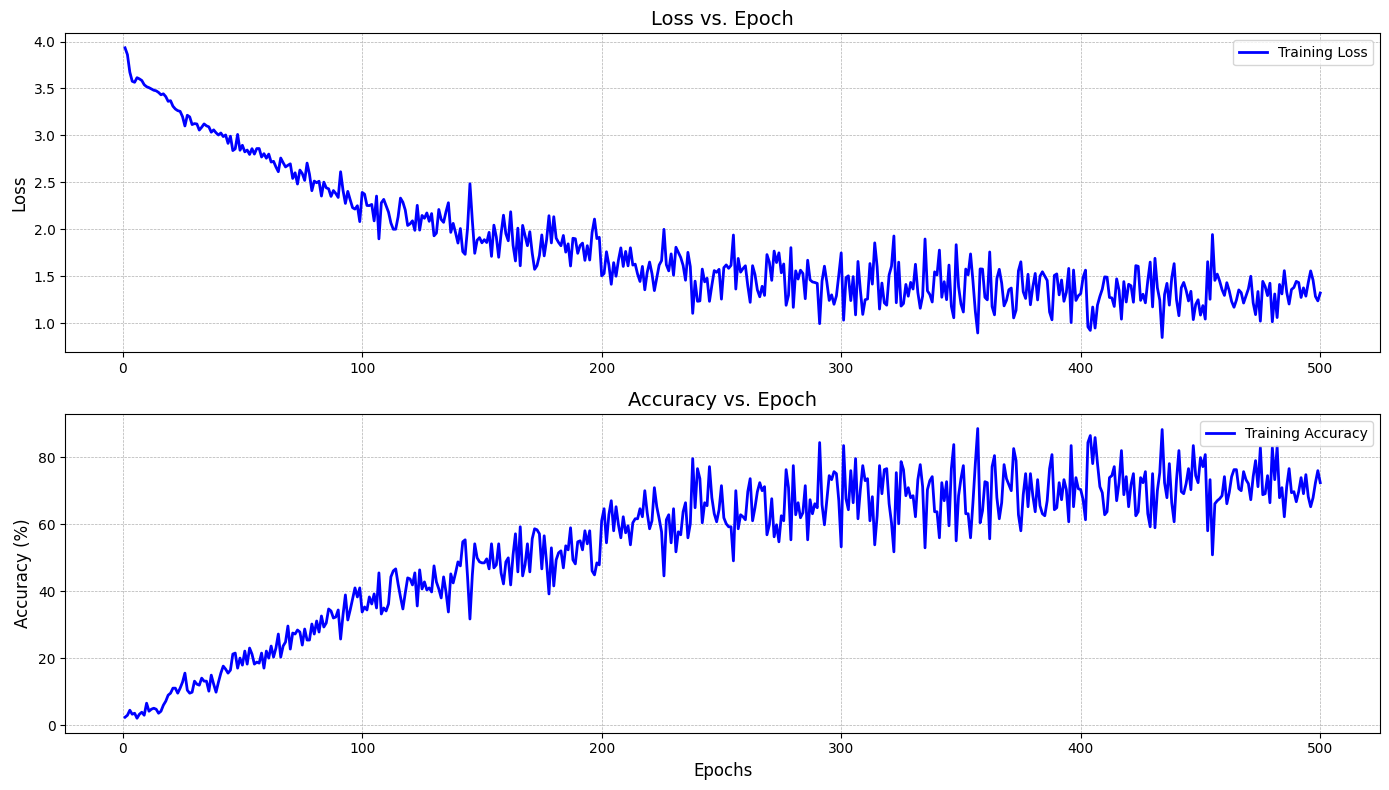

In [37]:
def plot_training_results(train_loss, train_acc, val_loss=None, val_acc=None):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(14, 8)) # (Width, Height)

    # loss plot
    plt.subplot(2, 1, 1) # (Rows, Cols, Index)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss', linewidth=2)
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'r-', label='Validation Loss', linewidth=2)
    plt.title('Loss vs. Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    # accuracy plot
    plt.subplot(2, 1, 2) # (Rows, Cols, Index)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy', linewidth=2)
    if val_acc is not None:
        plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy', linewidth=2)
    plt.title('Accuracy vs. Epoch', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

plot_training_results(train_losses, train_accs)

Test the SSTAN model.

In [31]:
# create test dataset
test_dataset = SignDataset(test_df, pose_dir, gloss_map)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

# load weights
if best_weight_path:
    model.load_state_dict(torch.load(best_weight_path))
    model.to(device)
model.eval()
results = []

test_correct, test_total = 0, 0
test_top5_correct = 0
test_loss = 0.0

with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader, desc='Testing')):
        inputs = batch["x"].to(device)
        labels = batch["label"].to(device)
        video_id = batch["video_id"].to(device)

        # forward pass
        logits = model(inputs)
        loss = criterion(logits, labels)

        # accumulate loss
        test_loss += loss.item()

        # top-1 and top-5 predicitons
        _, preds = logits.max(1)
        k = min(5, num_classes)
        _, top5 = logits.topk(k, 1, True, True)

        # store result
        is_correct = (preds == labels).item()
        is_top5 = (labels.unsqueeze(1) == top5).any().item()

        results.append({
            "video_id": video_id.item(),
            "label": labels.item(),
            "pred": preds.item(),
            "is_correct": is_correct
        })

        test_correct += is_correct
        test_top5_correct += is_top5
        test_total += 1

# calculate overall accuracy
test_accuracy = 100. * test_correct / test_total
test_top5_accuracy = 100. * test_top5_correct / test_total
avg_test_loss = test_loss / len(test_loader)

print(f'\nTest Results:')
print(f'Loss: {avg_test_loss:.4f}')
print(f'Top-1 Accuracy: {test_accuracy:.2f}% ({test_correct}/{test_total})')
print(f'Top-5 Accuracy: {test_top5_accuracy:.2f}% ({test_top5_correct}/{test_total})')

Testing: 100%|██████████| 60/60 [00:11<00:00,  5.37it/s]


Test Results:
Loss: 4.3227
Top-1 Accuracy: 25.00% (15/60)
Top-5 Accuracy: 56.67% (34/60)


Plot confusion matrix.

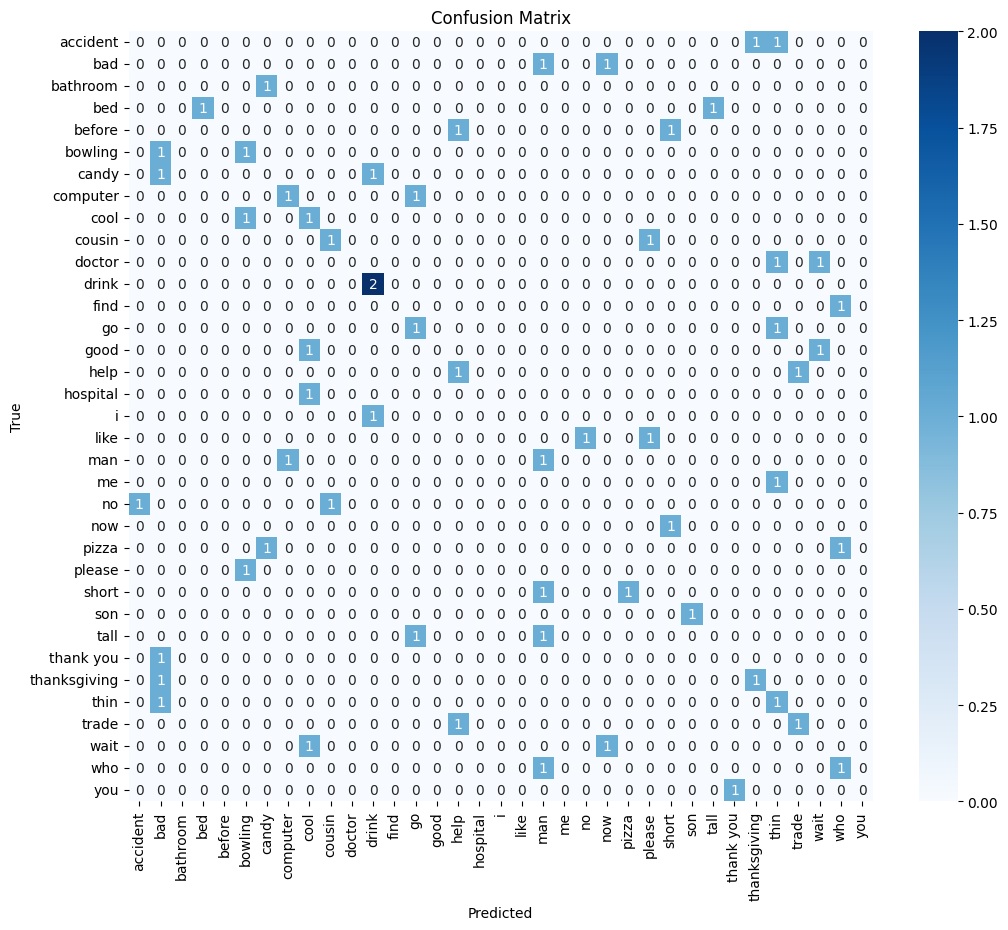

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# 1. Extract True Labels and Predictions from your results
y_true = [r['label'] for r in results]
y_pred = [r['pred'] for r in results]

# 2. Compute Confusion Matrix
# Get the class names from your gloss_map (reverse mapping: ID -> Gloss)
id_to_gloss = {v: k for k, v in gloss_map.items()}
class_names = [id_to_gloss[i] for i in range(len(gloss_map))]

cm = confusion_matrix(y_true, y_pred)

# --- VISUALIZATION OPTION 1: HEATMAP (Good for < 50 classes) ---
plt.figure(figsize=(12, 10))
# If you have too many classes, this might look crowded.
# Adjust 'figsize' or font_scale if needed.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

In [33]:
# --- VISUALIZATION OPTION 2: TOP CONFUSED PAIRS (Best for debugging) ---
# This is often more useful than the graph for Sign Language
print("\n--- Top Confused Pairs ---")
print("(True Label) -> (Predicted Label) : Count")

# Set diagonal to 0 to ignore correct predictions
np.fill_diagonal(cm, 0)

# Flatten and sort to find max confusion
pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if cm[i, j] > 0:
            pairs.append((cm[i, j], class_names[i], class_names[j]))

# Sort by count (descending)
pairs.sort(key=lambda x: x[0], reverse=True)

# Print top 10 mistakes
for count, true_cls, pred_cls in pairs[:10]:
    print(f" {true_cls:<15} -> {pred_cls:<15} : {count} errors")


--- Top Confused Pairs ---
(True Label) -> (Predicted Label) : Count
 accident        -> thanksgiving    : 1 errors
 accident        -> thin            : 1 errors
 bad             -> man             : 1 errors
 bad             -> now             : 1 errors
 bathroom        -> candy           : 1 errors
 bed             -> tall            : 1 errors
 before          -> help            : 1 errors
 before          -> short           : 1 errors
 bowling         -> bad             : 1 errors
 candy           -> bad             : 1 errors
